# Модуль 10. **Згорткові нейронні мережі** 
## Частина 1

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

from keras.datasets import fashion_mnist

from keras import layers, models

# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [2]:
print("TensorFlow", tf.__version__)
# Ensure we see the GPU in device list in the macOS.
# print('Visible Devices: ', tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

TensorFlow 2.16.2


In [22]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
CYAN = "\033[36m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання
**Частина 1**

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

<div class="alert alert-block"> В попередньому ДЗ було досягнуто точність <b>90.72%</b><br>
Намагатимемося досягти кращого результату, застосовуючи вже відпрацьовану методику до нових моделей</div>

     Завантаження та аналіз даних 

In [23]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [24]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [25]:
class_names = [
    "T-shirt/top",  # "Футболка/майка",
    "Trouser",  # "Штани",
    "Pullover",  # "Світшот",
    "Dress",  # "Сукня",
    "Coat",  # "Пальто",
    "Sandal",  # "Сандалі",
    "Shirt",  # "Сорочка",
    "Sneaker",  # "Кросівки",
    "Bag",  # "Сумка",
    "Ankle boot",  # "Ботильйони",
]

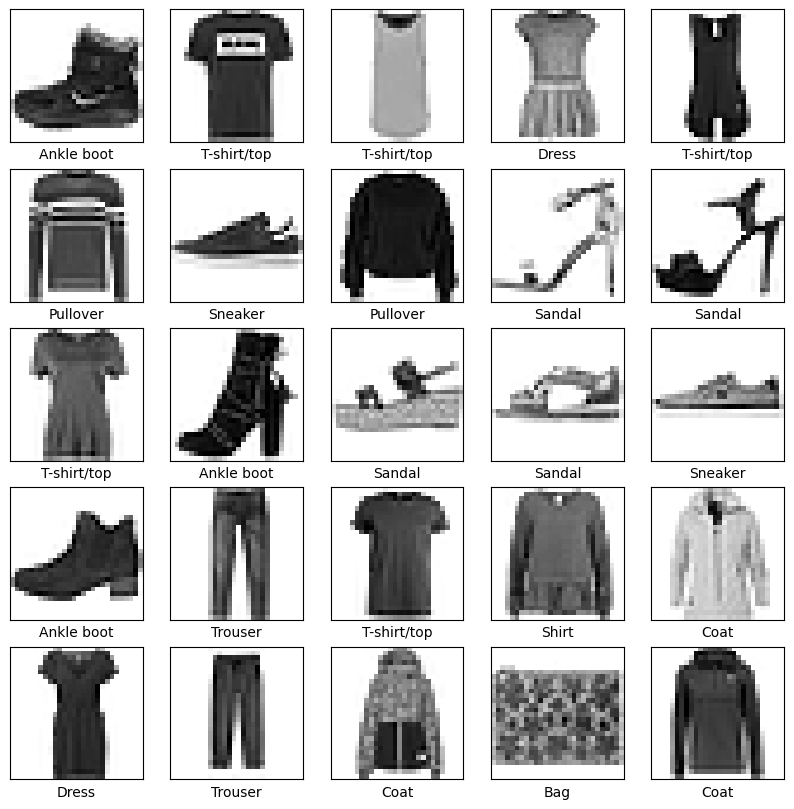

In [26]:
num_to_plot = 25

plt.figure(figsize=(10, 10))

for i in range(num_to_plot):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show() 

### Допоміжні функції

     Функція друку поточних параметрів 
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [27]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

     Функція відображення графіків історії точності та втрат 
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [28]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    plt.ylim(0, 1)
    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

     Функція підготовки моделі 
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [29]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)

    model.compile(
        optimizer=optimizer(learning_rate=lr_schedule),
        loss=loss_function,
        metrics=metrics,
    )
    # model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

     Функція формування callback 
######      Аргументи: <br>1.  callbacks - Список callback'ів<br>2. patience - Кількість епох без покращення, після яких швидкість навчання буде знижена<br>3. factor_lr - Коефіцієнт, на який швидкість навчання буде знижена _(new_lr = lr * factor)_

In [30]:
def make_callback(callbacks, patience=5, factor_lr=0.4, min_lr=1e-8):

    callback = []

    if "ReduceLROnPlateau" in callbacks:
        callback.append(
            ReduceLROnPlateau(
                monitor="val_loss", factor=factor_lr, patience=patience, min_lr=min_lr
            )
        )
    if "EarlyStopping" in callbacks:
        callback.append(
            EarlyStopping(
                monitor="val_accuracy", patience=patience, restore_best_weights=True
            )
        )
    return callback

     Функція тренування моделі 
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [31]:
def train_model(
    train_images,
    train_labels,
    test_images,
    test_labels,
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    callbacks,
    patience,
    factor_lr,
    verbose=0,
    summary=0,
):

    callback = make_callback(
        callbacks,
        patience,
        factor_lr,
    )

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        callbacks=callback,
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return history, test_acc

     Функція пошуку оптимальних параметрів 

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [32]:
def find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func,
    train_images=train_images,
    train_labels=train_labels,
    test_images=test_images,
    test_labels=test_labels,
    best_accuracy = 0.0,
    verbose=0,
    summary=0,
):

    # best_accuracy = 0.0
    # best_parameters = {}
    best_accuracy = best_accuracy
    best_parameters = optimal_parameters
    print(f">>>    {best_parameters = }")
    print(f">>> {optimal_parameters = }")

    for param in study_sequence:

        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                train_images,
                train_labels,
                test_images,
                test_labels,
                model_func,
                verbose=verbose,
                summary=summary,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

     Параметри для тренування моделей 

In [33]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 16,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 32,
    "activation": "relu",
    "metrics": ["accuracy"],
    "callbacks": ["ReduceLROnPlateau", ],
    "factor_lr": 0.2, 
    "patience": 5,
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "callbacks": [
        [""],
        ["ReduceLROnPlateau"],
        ["EarlyStopping"],
        ["ReduceLROnPlateau", "EarlyStopping"],
    ],
    "factor_lr": [0.2, 0.4, 0.6, 0.8], 
    "patience": [3, 4, 5, 6, 7, 8],
    "epochs": [5, 10, 15, 20],
    "batch_size": [8, 16, 32, 64],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "loss_function": [
        "sparse_categorical_crossentropy",
    ],
    "optimizer": ["adam", "sgd", "rmsprop"],
    "hidden_units": [16, 32, 64, 128],
    "activation": ["relu", "sigmoid"],
    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. **Conv2D** (32, (3, 3), input_shape=(28, 28, 1))

2. **MaxPooling2D** ((2, 2))

3. **Conv2D** (64, (3, 3))

4. **MaxPooling2D** ((2, 2))

5. **Flatten**

6. **Dense** 

7. **Dense** (10)

In [34]:
def model_CNN_1(hidden_units, activation, dropout_rate):

    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

     Параметри, для навчання моделі 1 
###### study_sequence - Послідовність дослідження

In [35]:
study_sequence = [
    "callbacks",
    "optimizer",
    "activation",
    "hidden_units",
    # "dropout_rate",
    "batch_size",
    "epochs",
    "callbacks",
    "factor_lr",
    "patience",
    # # "loss_function",
    # # # "metrics",
    "optimizer",
    "activation",
    "hidden_units",
    # "dropout_rate",
    "batch_size",
    "epochs",
    "callbacks",
    "patience",
    "factor_lr",
]

Пошук оптимальних параметрів для моделі  **model_CNN_1**

Пошук оптимального значення параметра: callbacks 
--------------------------------------------------
Тестується значення: callbacks = ['']
--------------------------------------------------


c:\Users\ks797\AppData\Local\pypoetry\Cache\virtualenvs\ds-rEpFRPgy-py3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1063
          тренувальні дані:   0.9602833390235901 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9066 - loss: 0.3044
          тестові дані:       0.9092000126838684 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5


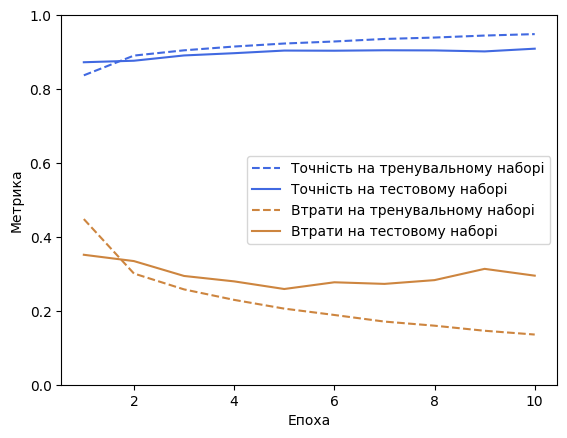

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9480 - loss: 0.1382
          тренувальні дані:   0.9476666450500488 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9043 - loss: 0.3009
          тестові дані:       0.906000018119812 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau']
 factor_lr 	= 0.2
 patience 	= 5


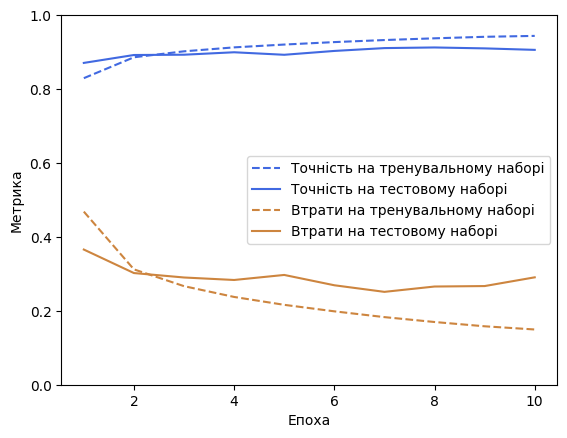

--------------------------------------------------
Тестується значення: callbacks = ['EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9520 - loss: 0.1281
          тренувальні дані:   0.9506999850273132 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9085 - loss: 0.2878
          тестові дані:       0.9089000225067139 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


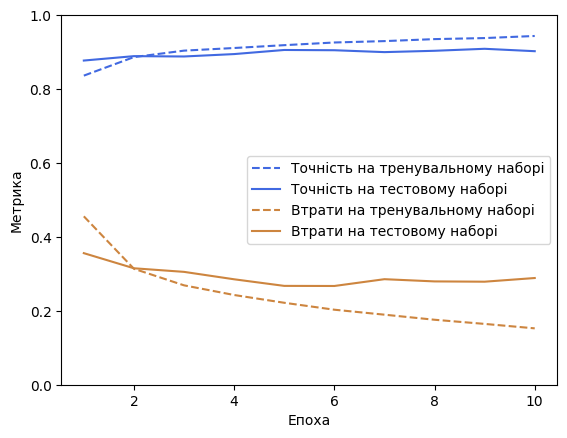

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9441 - loss: 0.1534
          тренувальні дані:   0.9433500170707703 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9105 - loss: 0.2649
          тестові дані:       0.9093999862670898 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


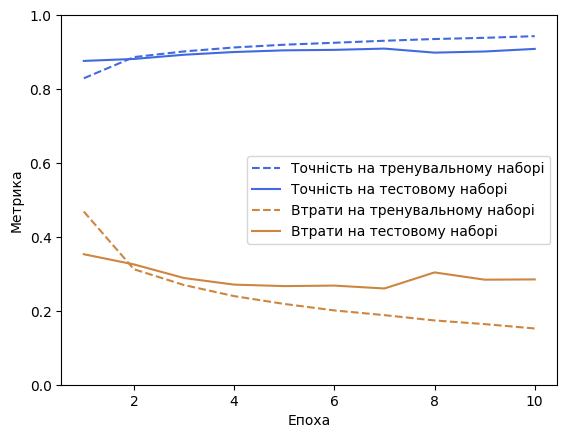

 Оптимальне значення параметра callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
   точність на тестових даних: 0.9093999862670898

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9490 - loss: 0.1406
          тренувальні дані:   0.9479833245277405 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9098 - loss: 0.2681
          тестові дані:       0.9103000164031982 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


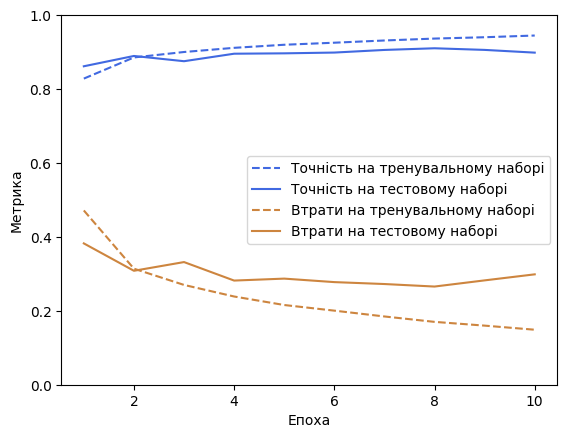

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9047 - loss: 0.2638
          тренувальні дані:   0.9034500122070312 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8843 - loss: 0.3216
          тестові дані:       0.8855999708175659 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


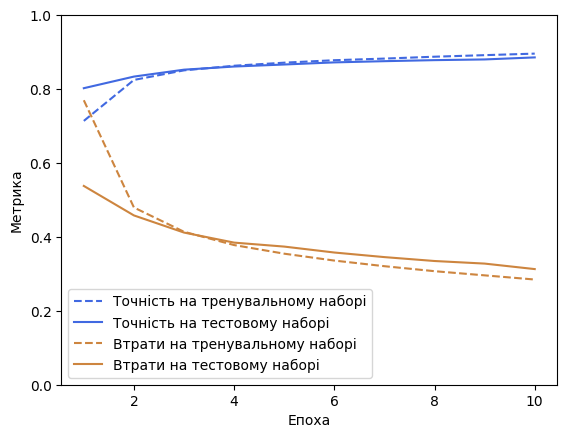

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9523 - loss: 0.1377
          тренувальні дані:   0.9506333470344543 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9152 - loss: 0.2821
          тестові дані:       0.9125000238418579 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


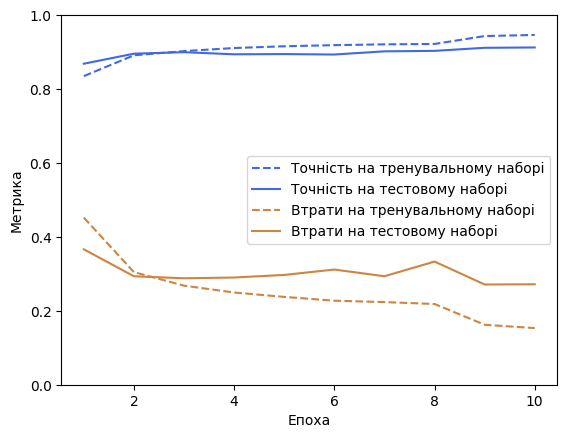

 Оптимальне значення параметра optimizer = rmsprop
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9241 - loss: 0.2148
          тренувальні дані:   0.9238666892051697 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9028 - loss: 0.3032
          тестові дані:       0.902400016784668 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


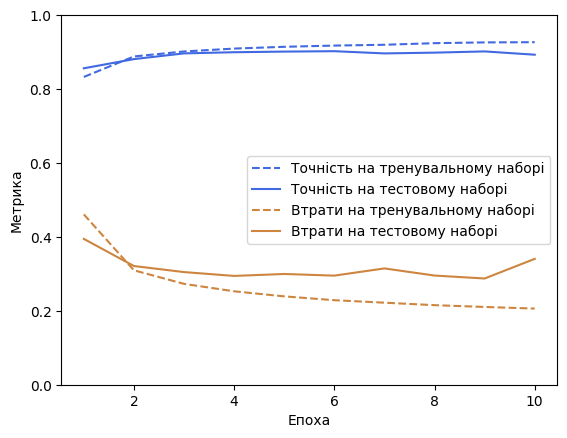

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8912 - loss: 0.2979
          тренувальні дані:   0.8901166915893555 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3605
          тестові дані:       0.8776999711990356 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


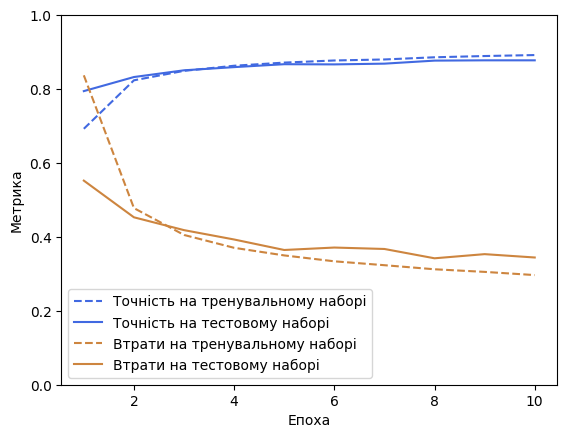

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9466 - loss: 0.1502
          тренувальні дані:   0.9464499950408936 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9037 - loss: 0.2976
          тестові дані:       0.9101999998092651 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 16
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


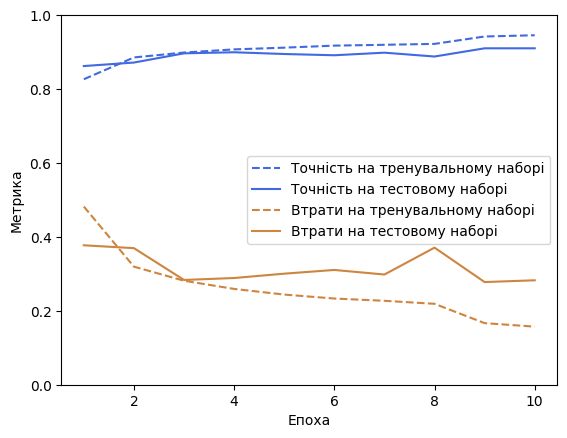

--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9334 - loss: 0.1857
          тренувальні дані:   0.9325500130653381 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8991 - loss: 0.3295
          тестові дані:       0.9007999897003174 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


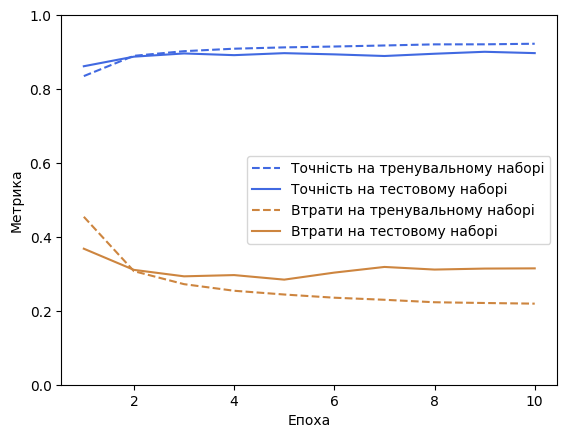

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9486 - loss: 0.1504
          тренувальні дані:   0.9478499889373779 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9042 - loss: 0.3369
          тестові дані:       0.9071000218391418 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


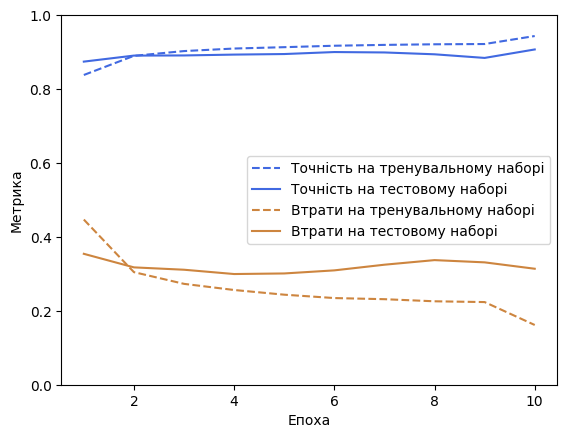

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9299 - loss: 0.1981
          тренувальні дані:   0.9279833436012268 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9019 - loss: 0.3133
          тестові дані:       0.9016000032424927 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


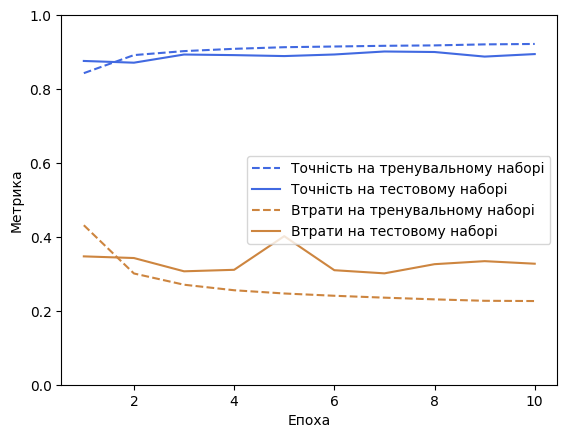

 Оптимальне значення параметра hidden_units = 32
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8979 - loss: 0.2886
          тренувальні дані:   0.8982333540916443 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8890 - loss: 0.3487
          тестові дані:       0.885699987411499 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


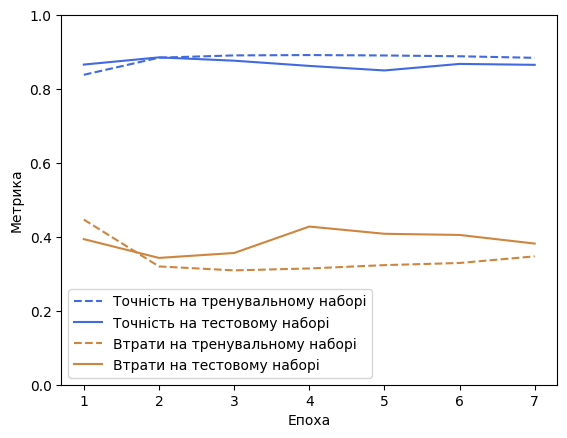

--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9465 - loss: 0.1507
          тренувальні дані:   0.9449166655540466 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9032 - loss: 0.3037
          тестові дані:       0.9052000045776367 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


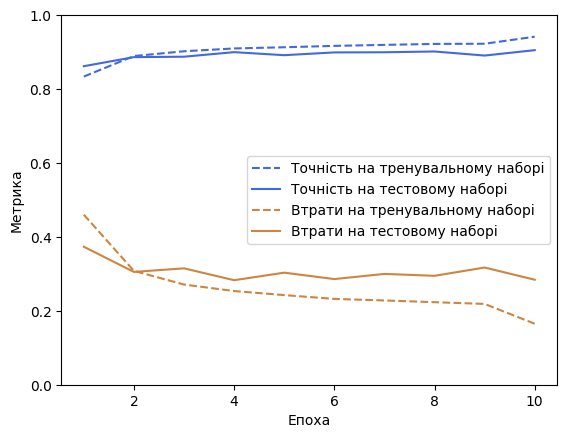

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.1539
          тренувальні дані:   0.9429833292961121 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9081 - loss: 0.2986
          тестові дані:       0.9075999855995178 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


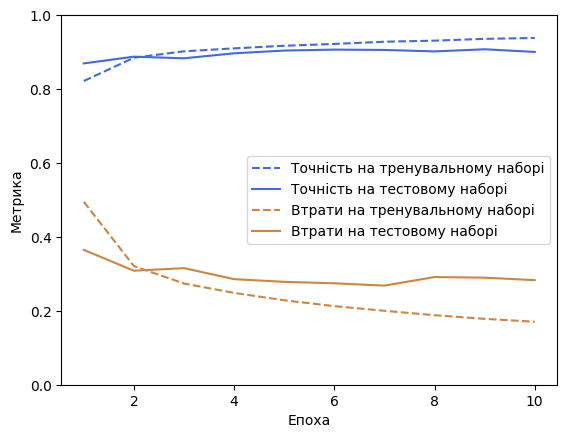

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9413 - loss: 0.1616
          тренувальні дані:   0.9410666823387146 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9026 - loss: 0.2804
          тестові дані:       0.9046000242233276 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


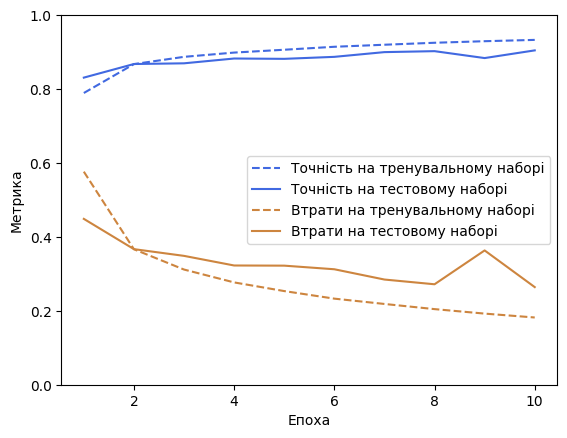

 Оптимальне значення параметра batch_size = 16
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9191 - loss: 0.2263
          тренувальні дані:   0.918483316898346 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8965 - loss: 0.3239
          тестові дані:       0.8960999846458435 
Поточні параметри:
 epochs 	= 5
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


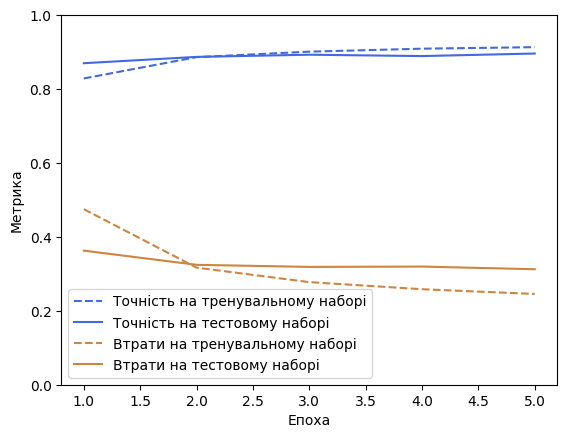

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9417 - loss: 0.1624
          тренувальні дані:   0.940833330154419 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2947
          тестові дані:       0.9064000248908997 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


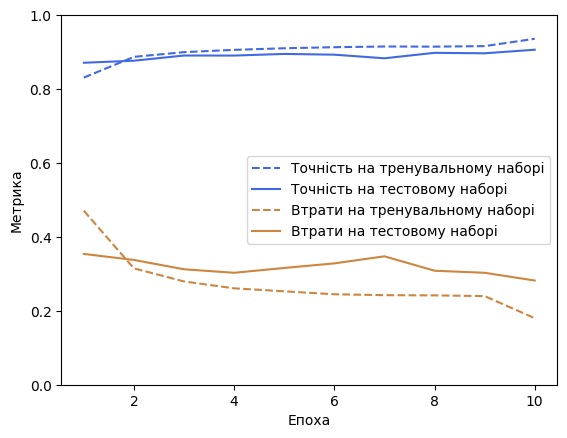

--------------------------------------------------
Тестується значення: epochs = 15
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9540 - loss: 0.1301
          тренувальні дані:   0.9536333084106445 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9074 - loss: 0.3089
          тестові дані:       0.9121000170707703 
Поточні параметри:
 epochs 	= 15
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


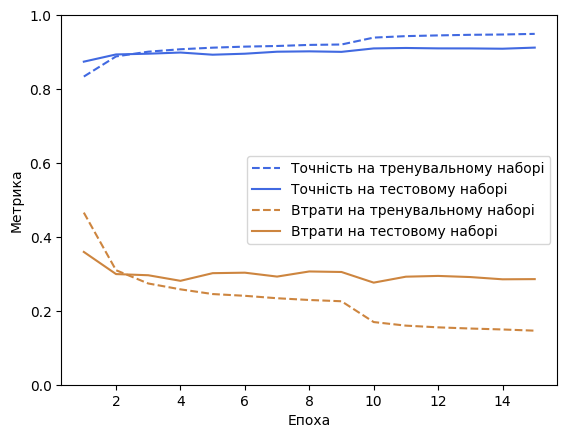

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9546 - loss: 0.1315
          тренувальні дані:   0.9531833529472351 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9078 - loss: 0.3081
          тестові дані:       0.9092000126838684 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


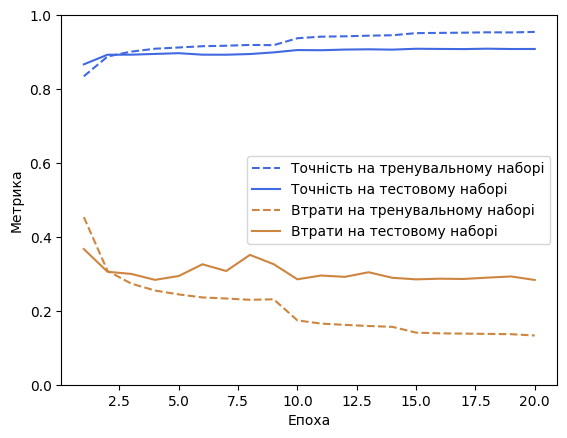

 Оптимальне значення параметра epochs = 10
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: callbacks 
--------------------------------------------------
Тестується значення: callbacks = ['']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9391 - loss: 0.1698
          тренувальні дані:   0.937166690826416 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9002 - loss: 0.3022
          тестові дані:       0.9006999731063843 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5


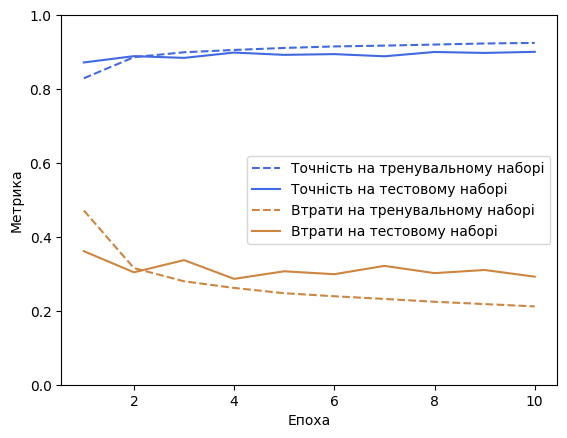

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9465 - loss: 0.1523
          тренувальні дані:   0.9444833397865295 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9070 - loss: 0.3024
          тестові дані:       0.9060999751091003 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau']
 factor_lr 	= 0.2
 patience 	= 5


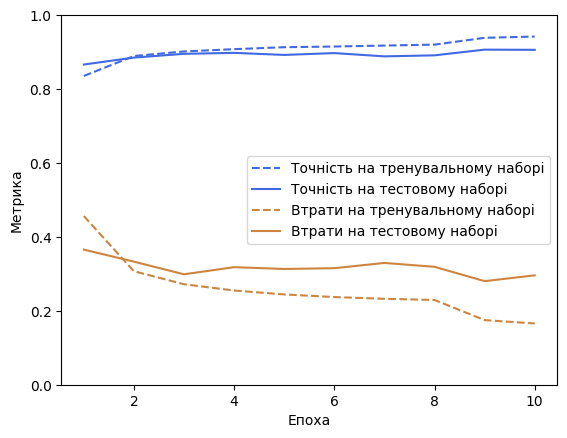

--------------------------------------------------
Тестується значення: callbacks = ['EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9252 - loss: 0.2155
          тренувальні дані:   0.9236833453178406 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8970 - loss: 0.3269
          тестові дані:       0.8999000191688538 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


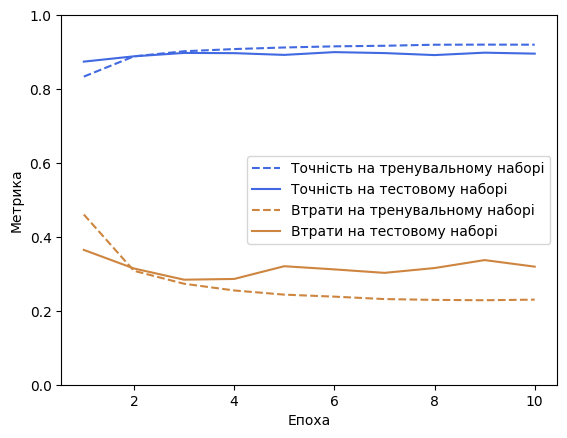

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9460 - loss: 0.1498
          тренувальні дані:   0.9462166428565979 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9079 - loss: 0.3075
          тестові дані:       0.9068999886512756 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


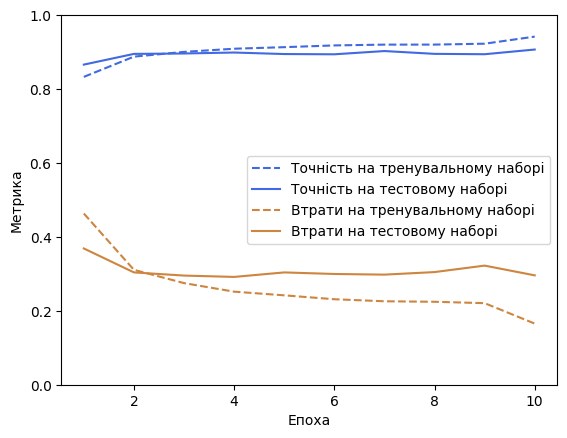

 Оптимальне значення параметра callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: factor_lr 
--------------------------------------------------
Тестується значення: factor_lr = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9453 - loss: 0.1547
          тренувальні дані:   0.9447000026702881 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9088 - loss: 0.2954
          тестові дані:       0.909600019454956 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


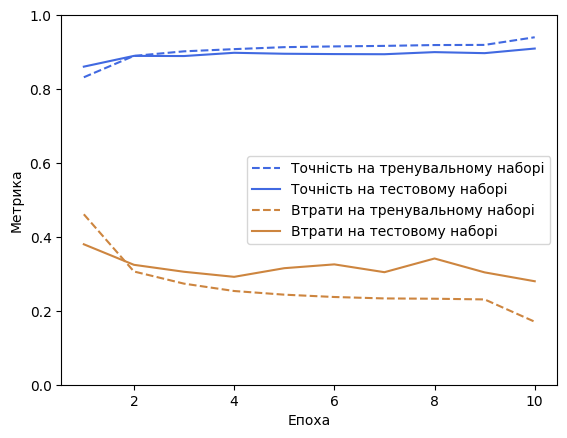

--------------------------------------------------
Тестується значення: factor_lr = 0.4
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9395 - loss: 0.1675
          тренувальні дані:   0.9398166537284851 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9047 - loss: 0.3210
          тестові дані:       0.9023000001907349 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.4
 patience 	= 5


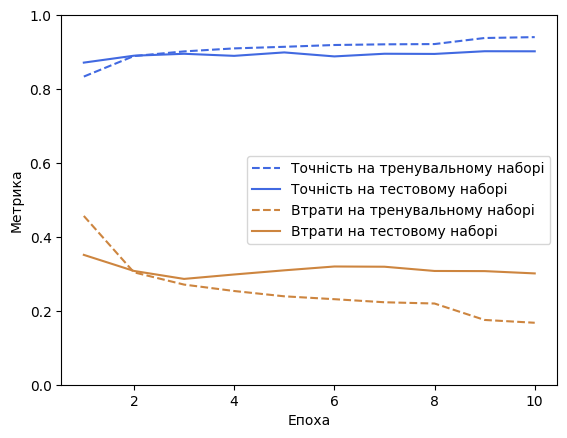

--------------------------------------------------
Тестується значення: factor_lr = 0.6
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9225 - loss: 0.2155
          тренувальні дані:   0.9216333627700806 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9004 - loss: 0.3013
          тестові дані:       0.899399995803833 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.6
 patience 	= 5


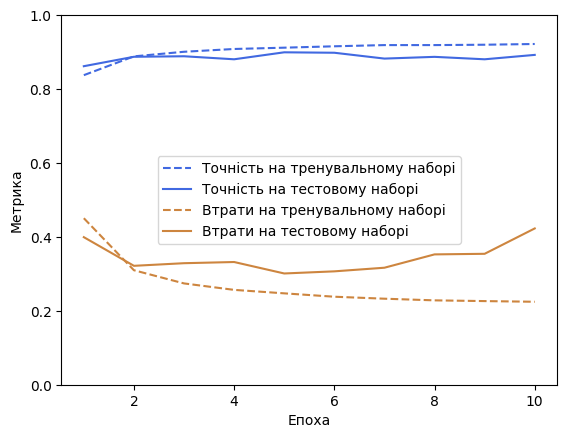

--------------------------------------------------
Тестується значення: factor_lr = 0.8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9309 - loss: 0.1954
          тренувальні дані:   0.930649995803833 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8981 - loss: 0.3253
          тестові дані:       0.9004999995231628 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.8
 patience 	= 5


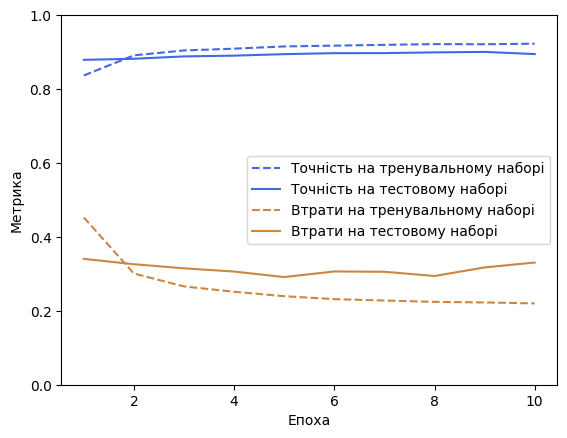

 Оптимальне значення параметра factor_lr = 0.2
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: patience 
--------------------------------------------------
Тестується значення: patience = 3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9266 - loss: 0.2027
          тренувальні дані:   0.9256500005722046 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9019 - loss: 0.2933
          тестові дані:       0.8996999859809875 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 3


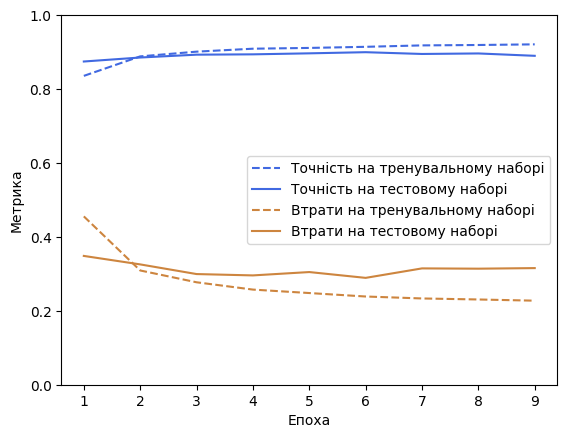

--------------------------------------------------
Тестується значення: patience = 4
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9303 - loss: 0.1935
          тренувальні дані:   0.9292500019073486 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9064 - loss: 0.2853
          тестові дані:       0.9035999774932861 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 4


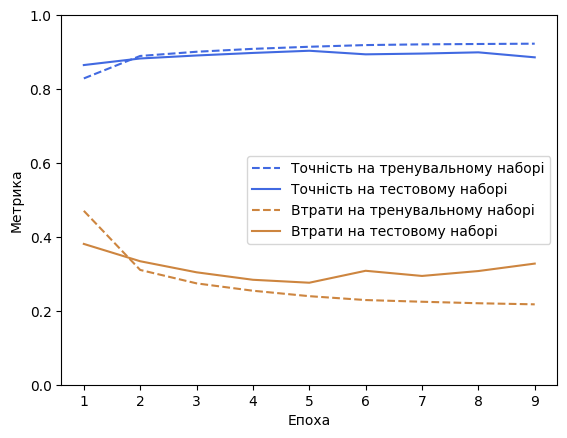

--------------------------------------------------
Тестується значення: patience = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9442 - loss: 0.1599
          тренувальні дані:   0.9434333443641663 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9079 - loss: 0.2824
          тестові дані:       0.909500002861023 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


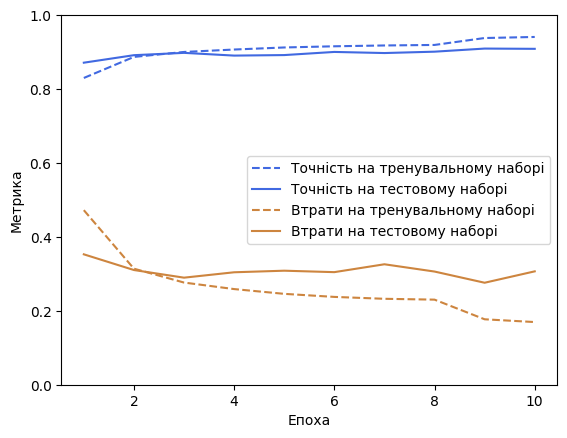

--------------------------------------------------
Тестується значення: patience = 6
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9273 - loss: 0.2005
          тренувальні дані:   0.9266666769981384 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8979 - loss: 0.2963
          тестові дані:       0.8992000222206116 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 6


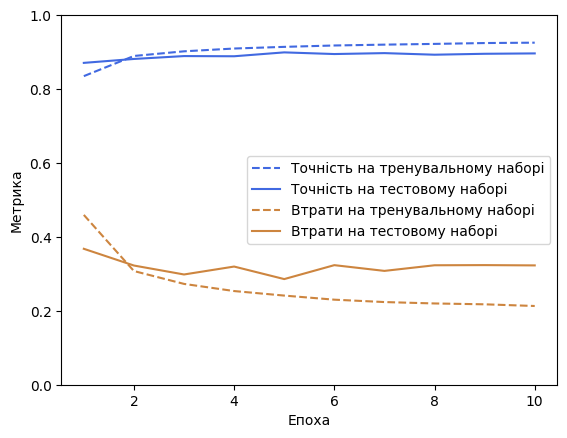

--------------------------------------------------
Тестується значення: patience = 7
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9290 - loss: 0.2030
          тренувальні дані:   0.9271000027656555 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9003 - loss: 0.3005
          тестові дані:       0.9035000205039978 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 7


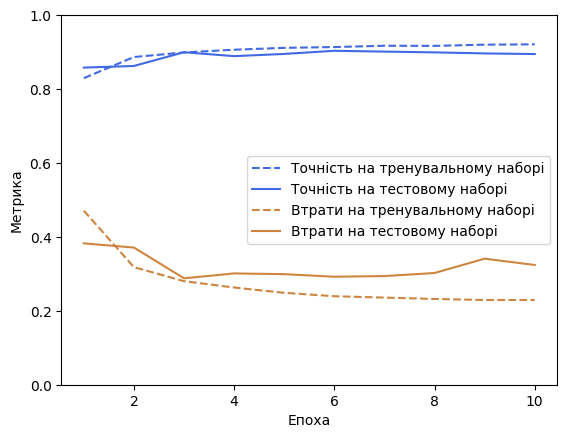

--------------------------------------------------
Тестується значення: patience = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9327 - loss: 0.1932
          тренувальні дані:   0.9300333261489868 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8991 - loss: 0.3309
          тестові дані:       0.9003999829292297 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 8


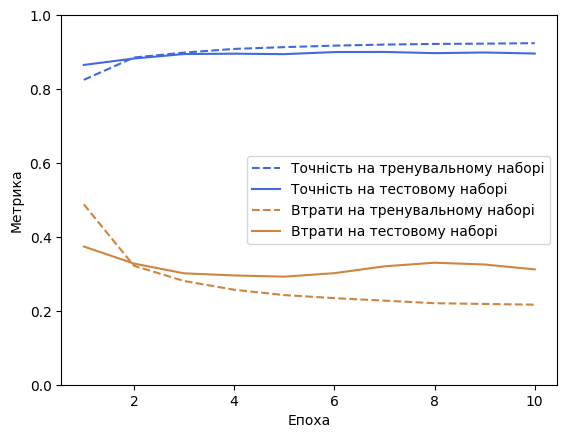

 Оптимальне значення параметра patience = 5
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9427 - loss: 0.1564
          тренувальні дані:   0.9420999884605408 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9065 - loss: 0.2636
          тестові дані:       0.9060999751091003 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


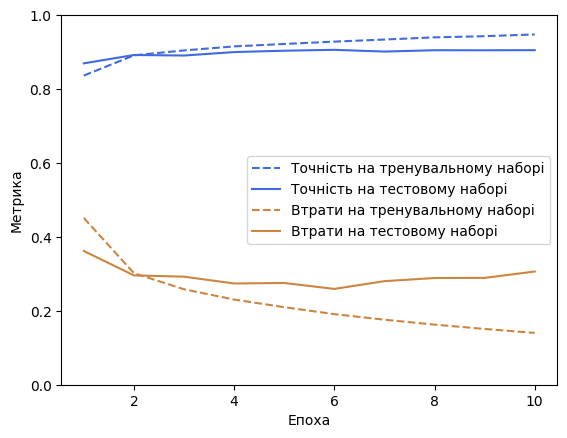

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9008 - loss: 0.2738
          тренувальні дані:   0.9000666737556458 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8872 - loss: 0.3252
          тестові дані:       0.8870999813079834 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


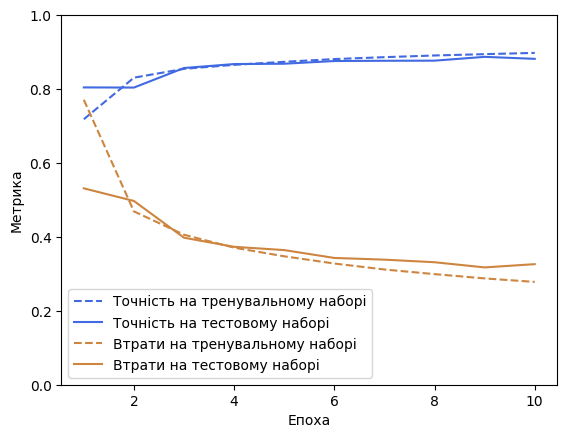

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9263 - loss: 0.2084
          тренувальні дані:   0.9239166378974915 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9017 - loss: 0.3269
          тестові дані:       0.900600016117096 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


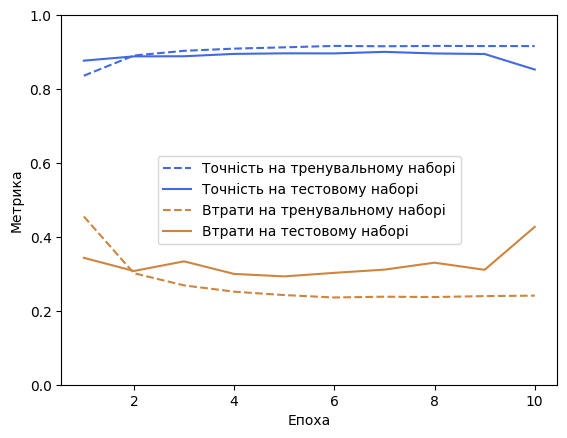

 Оптимальне значення параметра optimizer = rmsprop
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9185 - loss: 0.2289
          тренувальні дані:   0.9187333583831787 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8997 - loss: 0.2986
          тестові дані:       0.8978000283241272 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


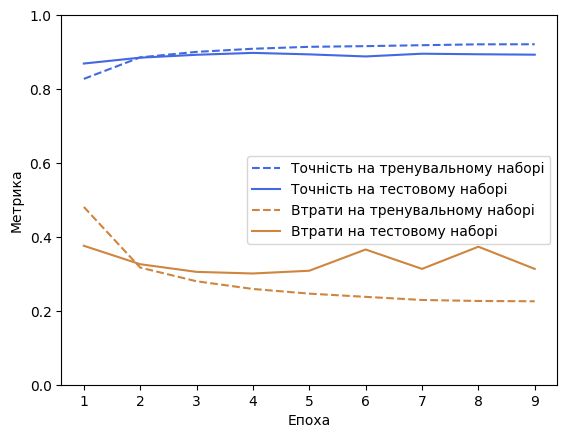

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8994 - loss: 0.2788
          тренувальні дані:   0.8977333307266235 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8832 - loss: 0.3303
          тестові дані:       0.8833000063896179 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


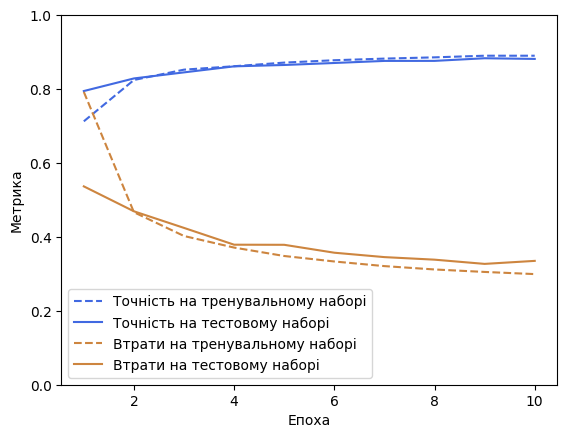

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.9125000238418579

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9276 - loss: 0.2096
          тренувальні дані:   0.927566647529602 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9034 - loss: 0.3125
          тестові дані:       0.8991000056266785 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 16
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


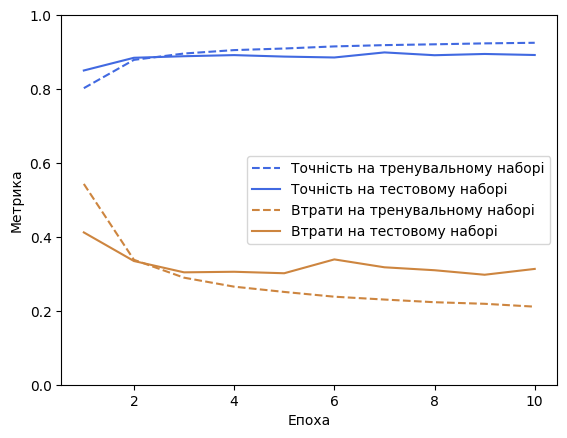

--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9335 - loss: 0.1838
          тренувальні дані:   0.9332833290100098 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9035 - loss: 0.2829
          тестові дані:       0.9031000137329102 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


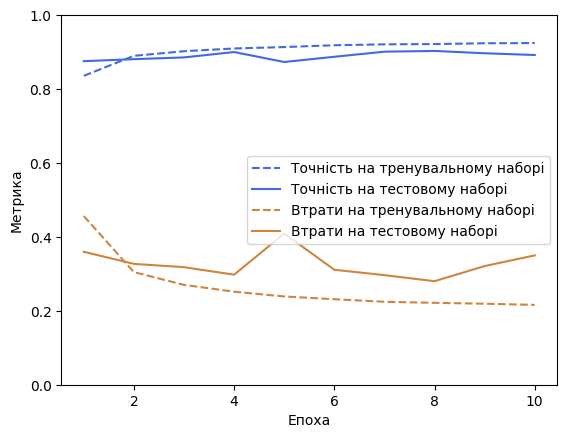

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9517 - loss: 0.1391
          тренувальні дані:   0.9506499767303467 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9135 - loss: 0.2766
          тестові дані:       0.9150999784469604 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


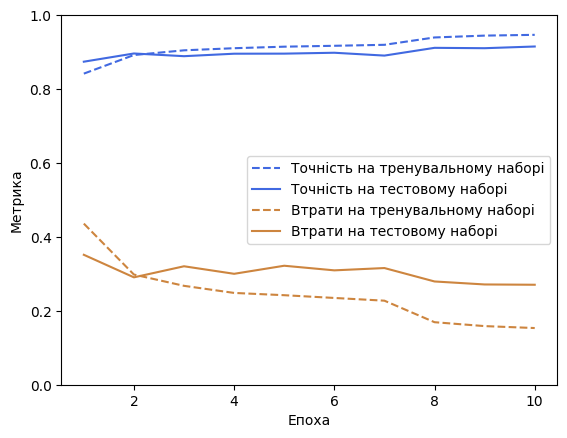

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9242 - loss: 0.2132
          тренувальні дані:   0.9218833446502686 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8978 - loss: 0.3092
          тестові дані:       0.8989999890327454 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


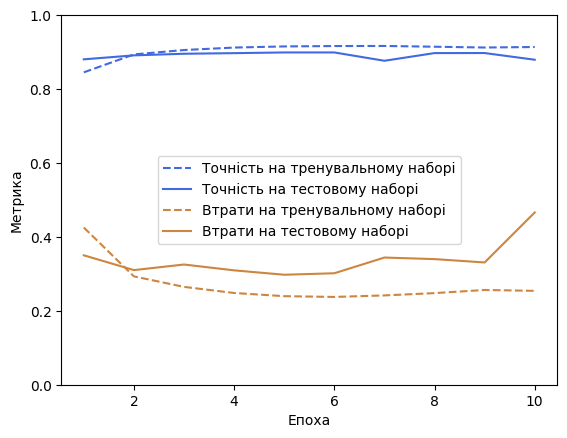

 Оптимальне значення параметра hidden_units = 64
   точність на тестових даних: 0.9150999784469604

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9231 - loss: 0.2216
          тренувальні дані:   0.9215999841690063 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8986 - loss: 0.3327
          тестові дані:       0.8967999815940857 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


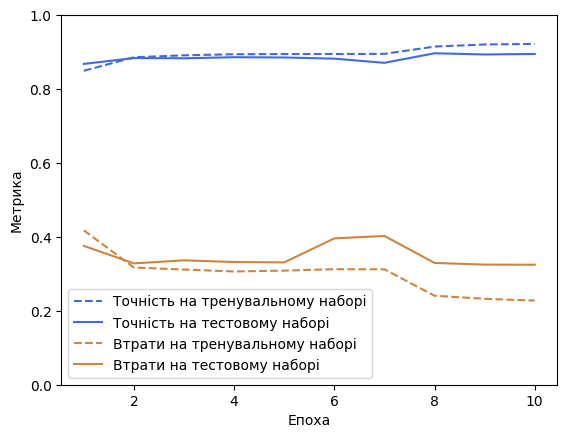

--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9232 - loss: 0.2189
          тренувальні дані:   0.9230333566665649 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8963 - loss: 0.3088
          тестові дані:       0.8967999815940857 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


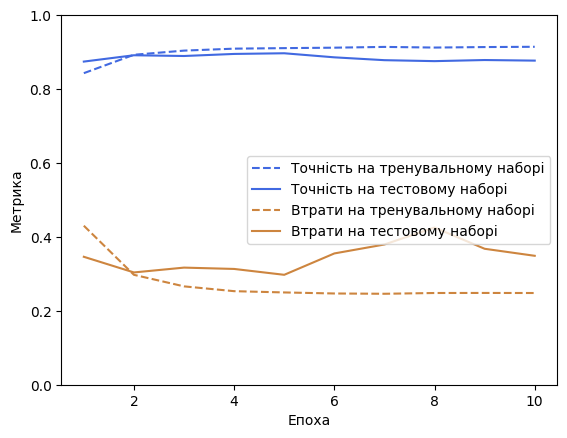

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9648 - loss: 0.1024
          тренувальні дані:   0.9633499979972839 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9170 - loss: 0.2799
          тестові дані:       0.9157999753952026 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


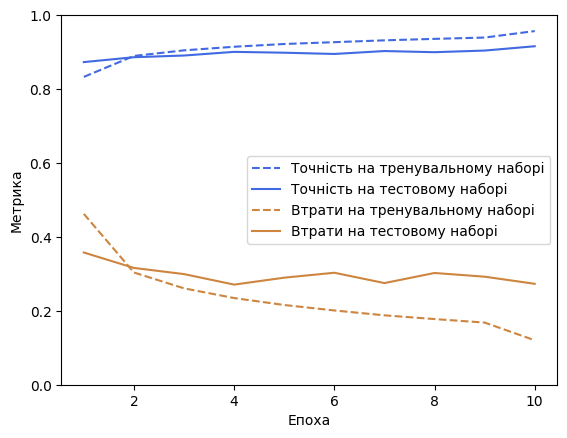

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9474 - loss: 0.1428
          тренувальні дані:   0.9470999836921692 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9051 - loss: 0.2754
          тестові дані:       0.9072999954223633 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


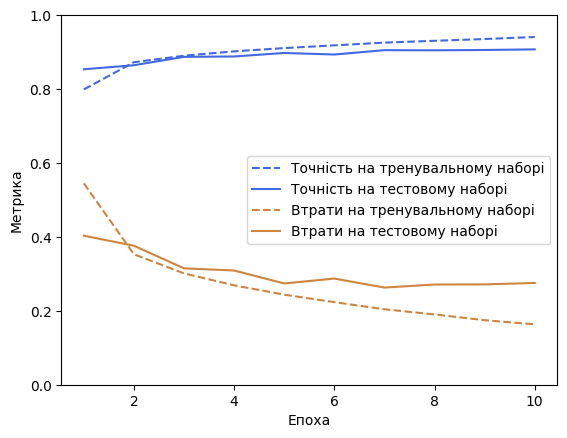

 Оптимальне значення параметра batch_size = 32
   точність на тестових даних: 0.9157999753952026

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9233 - loss: 0.2086
          тренувальні дані:   0.9222833514213562 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9047 - loss: 0.2874
          тестові дані:       0.9039999842643738 
Поточні параметри:
 epochs 	= 5
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


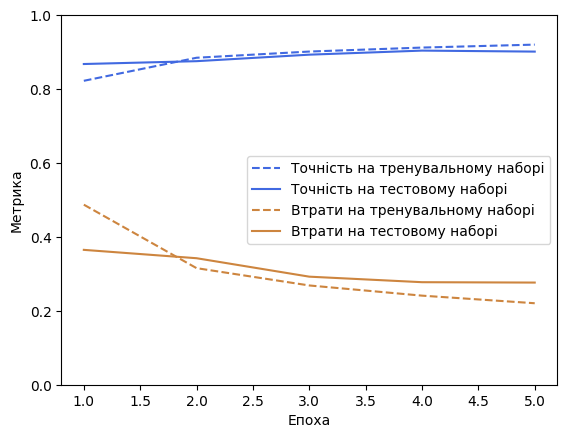

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9473 - loss: 0.1463
          тренувальні дані:   0.947350025177002 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9119 - loss: 0.2817
          тестові дані:       0.9104999899864197 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


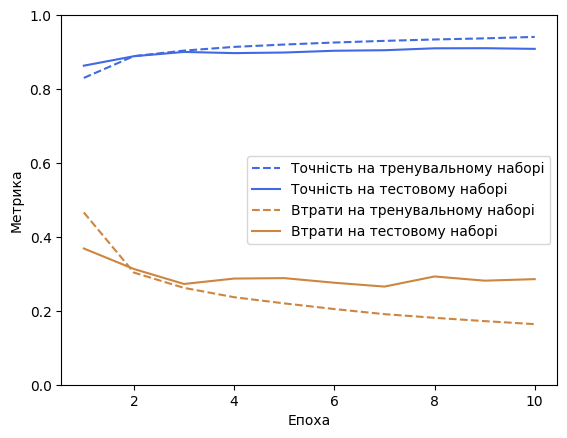

--------------------------------------------------
Тестується значення: epochs = 15
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9419 - loss: 0.1581
          тренувальні дані:   0.940850019454956 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9114 - loss: 0.2710
          тестові дані:       0.9108999967575073 
Поточні параметри:
 epochs 	= 15
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


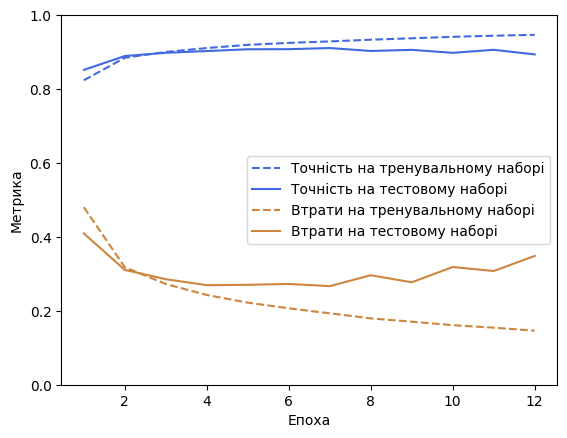

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9747 - loss: 0.0746
          тренувальні дані:   0.9744499921798706 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9151 - loss: 0.3125
          тестові дані:       0.9157000184059143 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


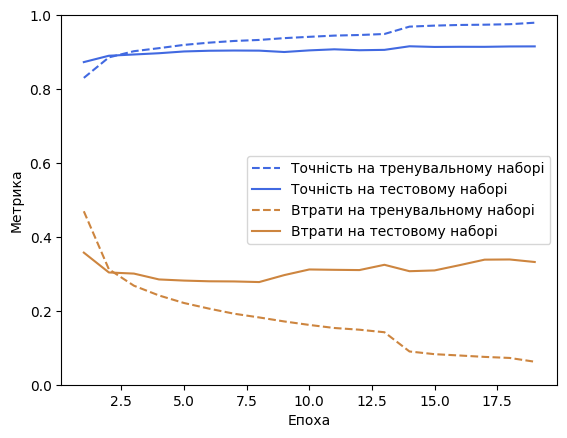

 Оптимальне значення параметра epochs = 10
   точність на тестових даних: 0.9157999753952026

Пошук оптимального значення параметра: callbacks 
--------------------------------------------------
Тестується значення: callbacks = ['']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9532 - loss: 0.1275
          тренувальні дані:   0.9525666832923889 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9000 - loss: 0.3106
          тестові дані:       0.9017000198364258 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5


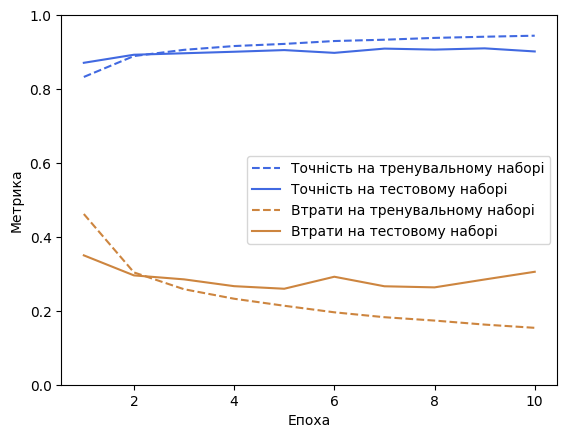

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9548 - loss: 0.1262
          тренувальні дані:   0.9535999894142151 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9066 - loss: 0.2946
          тестові дані:       0.9070000052452087 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau']
 factor_lr 	= 0.2
 patience 	= 5


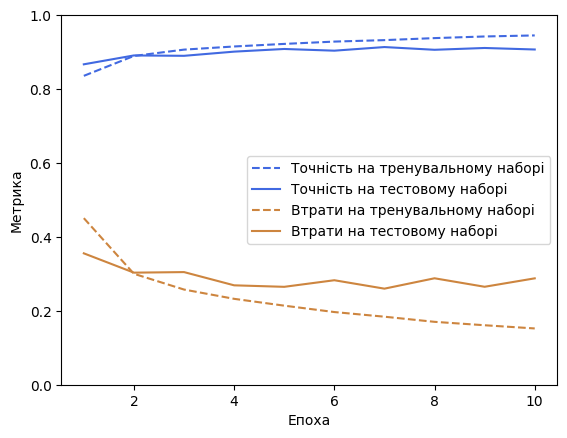

--------------------------------------------------
Тестується значення: callbacks = ['EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9546 - loss: 0.1266
          тренувальні дані:   0.9537666440010071 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9082 - loss: 0.2820
          тестові дані:       0.9115999937057495 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


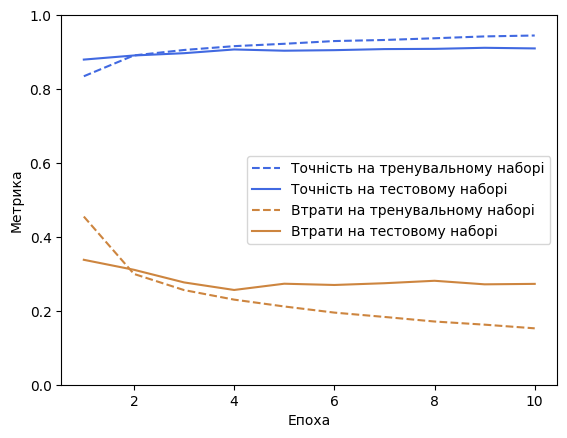

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9650 - loss: 0.0993
          тренувальні дані:   0.9641333222389221 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9138 - loss: 0.2742
          тестові дані:       0.9161999821662903 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


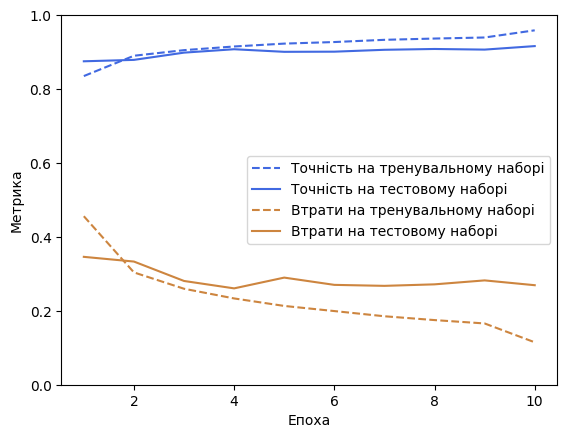

 Оптимальне значення параметра callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
   точність на тестових даних: 0.9161999821662903

Пошук оптимального значення параметра: patience 
--------------------------------------------------
Тестується значення: patience = 3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9441 - loss: 0.1537
          тренувальні дані:   0.9429500102996826 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9137 - loss: 0.2743
          тестові дані:       0.9128000140190125 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 3


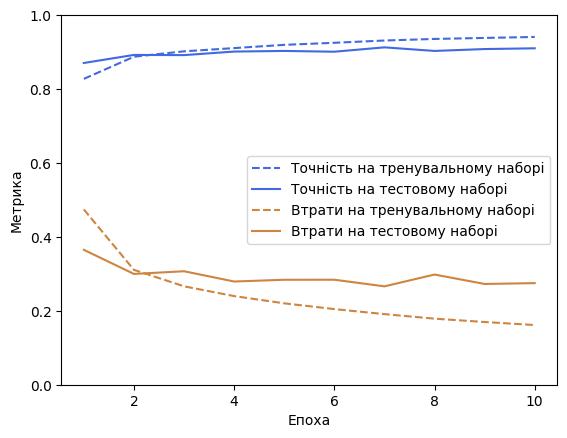

--------------------------------------------------
Тестується значення: patience = 4
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9430 - loss: 0.1580
          тренувальні дані:   0.9414166808128357 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9094 - loss: 0.2611
          тестові дані:       0.9110000133514404 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 4


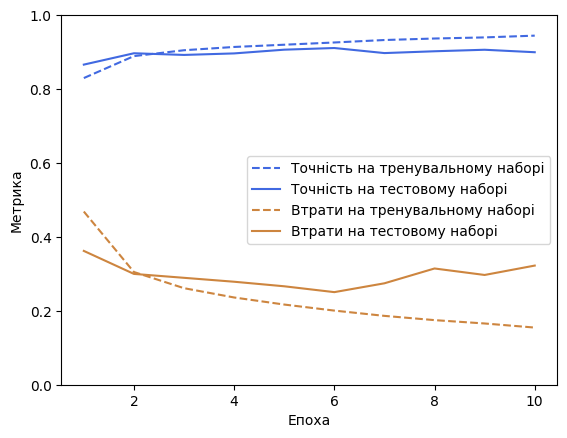

--------------------------------------------------
Тестується значення: patience = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9521 - loss: 0.1310
          тренувальні дані:   0.9509666562080383 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9144 - loss: 0.2820
          тестові дані:       0.9132999777793884 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


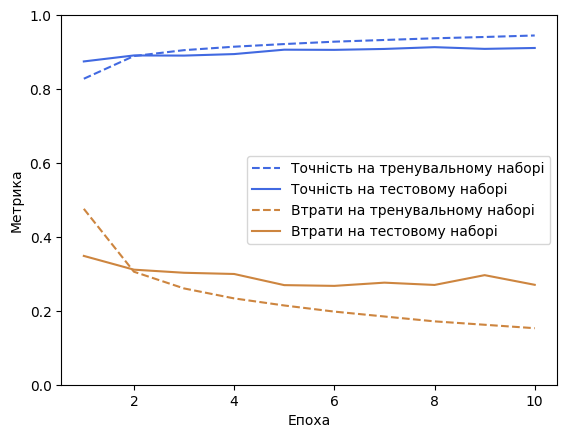

--------------------------------------------------
Тестується значення: patience = 6
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9514 - loss: 0.1368
          тренувальні дані:   0.9498833417892456 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9115 - loss: 0.2743
          тестові дані:       0.911300003528595 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 6


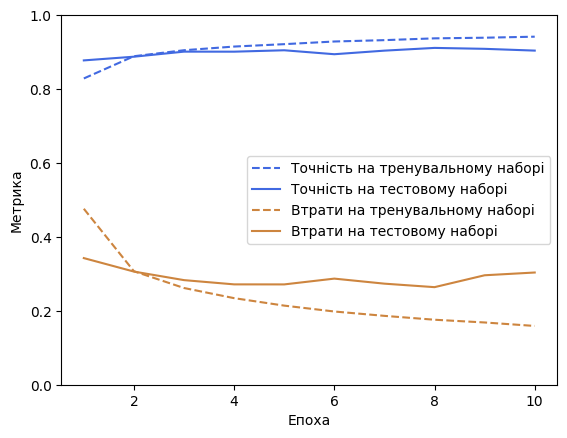

--------------------------------------------------
Тестується значення: patience = 7
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9444 - loss: 0.1562
          тренувальні дані:   0.943316638469696 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9058 - loss: 0.3352
          тестові дані:       0.9064000248908997 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 7


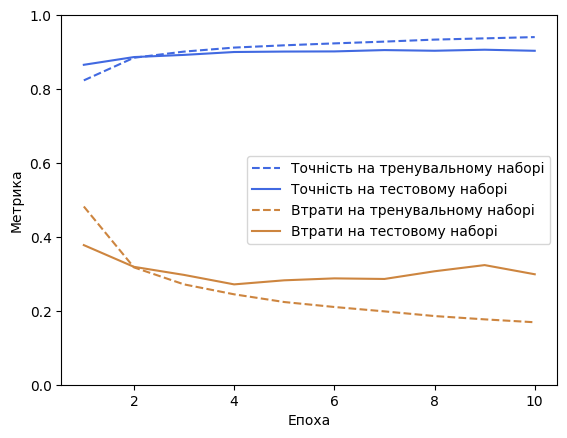

--------------------------------------------------
Тестується значення: patience = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9564 - loss: 0.1196
          тренувальні дані:   0.9559333324432373 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9115 - loss: 0.2999
          тестові дані:       0.9128000140190125 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 8


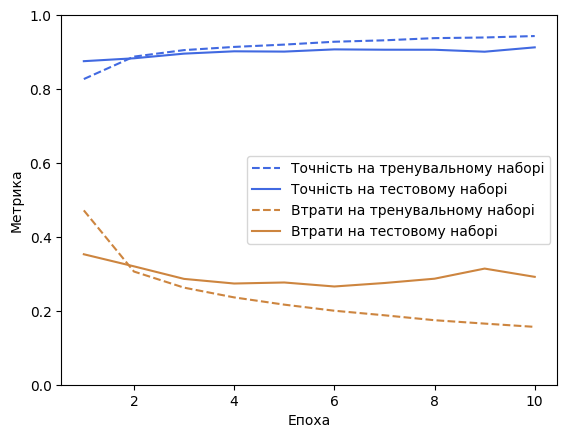

 Оптимальне значення параметра patience = 5
   точність на тестових даних: 0.9161999821662903

Пошук оптимального значення параметра: factor_lr 
--------------------------------------------------
Тестується значення: factor_lr = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9548 - loss: 0.1266
          тренувальні дані:   0.9531833529472351 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9096 - loss: 0.2834
          тестові дані:       0.9097999930381775 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


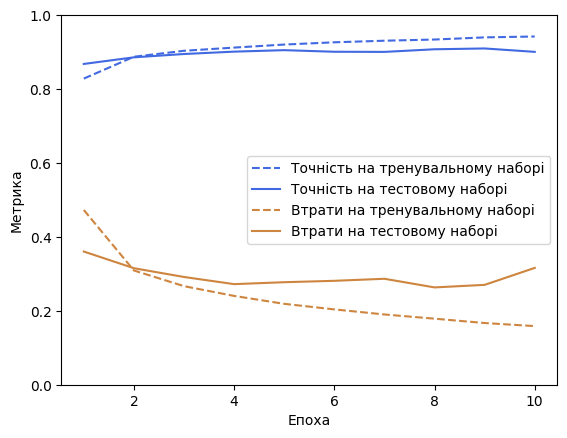

--------------------------------------------------
Тестується значення: factor_lr = 0.4
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9501 - loss: 0.1386
          тренувальні дані:   0.9486333131790161 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9019 - loss: 0.3050
          тестові дані:       0.9071999788284302 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.4
 patience 	= 5


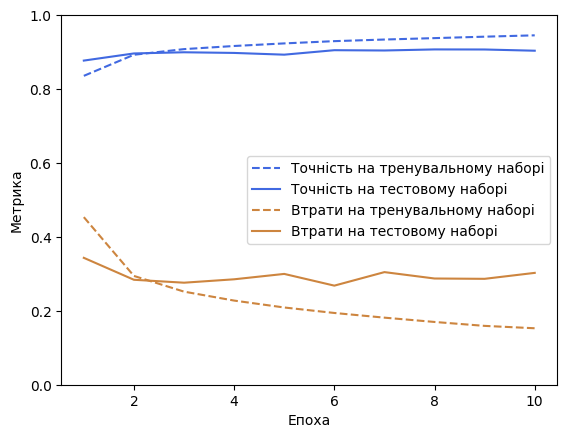

--------------------------------------------------
Тестується значення: factor_lr = 0.6
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9452 - loss: 0.1507
          тренувальні дані:   0.9438833594322205 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9091 - loss: 0.2964
          тестові дані:       0.9089000225067139 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.6
 patience 	= 5


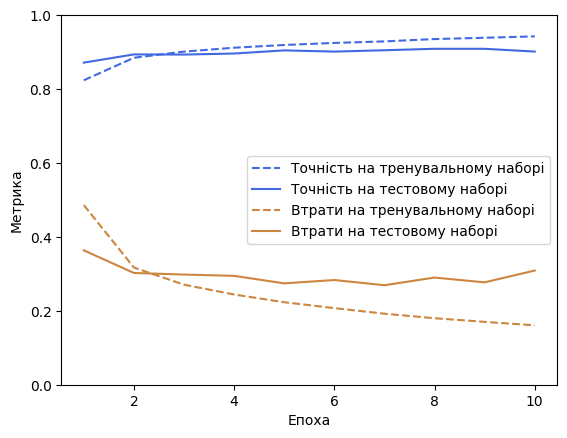

--------------------------------------------------
Тестується значення: factor_lr = 0.8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9506 - loss: 0.1321
          тренувальні дані:   0.9498999714851379 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9048 - loss: 0.3047
          тестові дані:       0.9070000052452087 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.8
 patience 	= 5


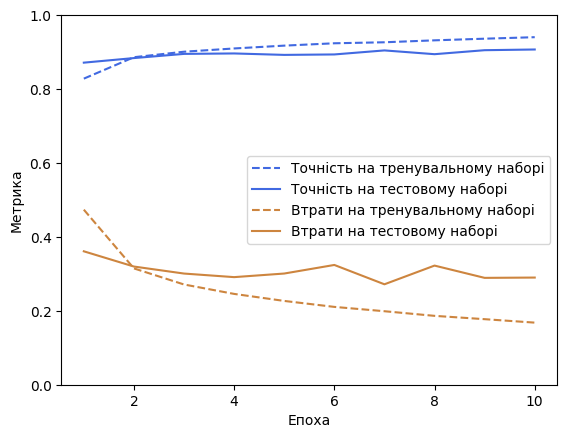

 Оптимальне значення параметра factor_lr = 0.2
   точність на тестових даних: 0.9161999821662903



In [36]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_1,
    # summary=1,
)

In [37]:
print_parameters(best_parameters, "Оптимальні параметри для model_CNN_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_CNN_1
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5
 Точність:        0.9161999821662903


<div class="alert alert-block alert-info">
<b>Висновки model_CN_1:</b> 
<p>Найпростіша згорткова нейромережа видає кращу точність, порівняно з мережею без згорток<br>Точність моделі склала <b>91.62%</b>)</p>
</div>

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових шари: **Conv2D** та **Dropout**_

In [38]:
def model_CNN_2(hidden_units, activation, dropout_rate):

    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),  # added in model_2
            layers.Flatten(),
            layers.Dropout(dropout_rate),  # added in model_2
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

     Оптимальні параметри, що було визначено під час дослідження 

In [39]:
print_parameters(best_parameters, "Оптимальні параметри для model_CNN_1")

Оптимальні параметри для model_CNN_1
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


In [40]:
study_sequence = [
    "callbacks",
    "optimizer",
    "activation",
    "hidden_units",
    "dropout_rate",
    "batch_size",
    "epochs",
    "callbacks",
    "factor_lr", 
    "patience",
    # # "loss_function",
    # # # "metrics",
]

Пошук оптимального значення параметра: callbacks 
--------------------------------------------------
Тестується значення: callbacks = ['']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9346 - loss: 0.1857
          тренувальні дані:   0.9325500130653381 
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8996 - loss: 0.2994
          тестові дані:       0.8998000025749207 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5


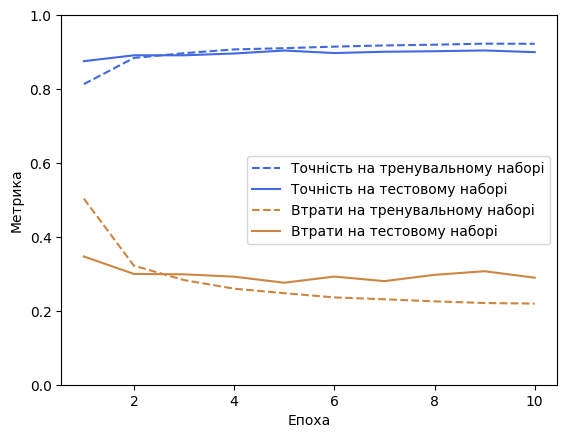

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9268 - loss: 0.2030
          тренувальні дані:   0.9262499809265137 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8954 - loss: 0.3670
          тестові дані:       0.8964999914169312 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau']
 factor_lr 	= 0.2
 patience 	= 5


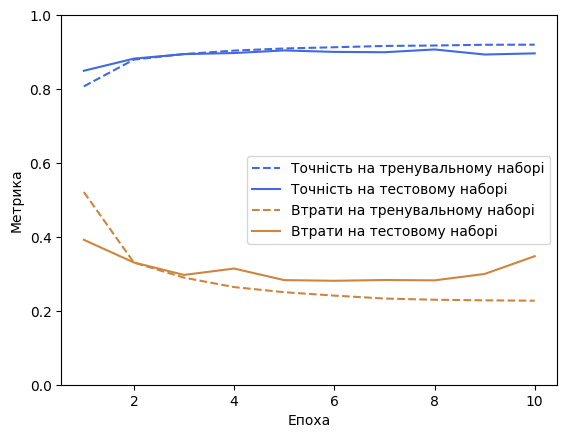

--------------------------------------------------
Тестується значення: callbacks = ['EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9268 - loss: 0.2029
          тренувальні дані:   0.9255666732788086 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9042 - loss: 0.2921
          тестові дані:       0.9032999873161316 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


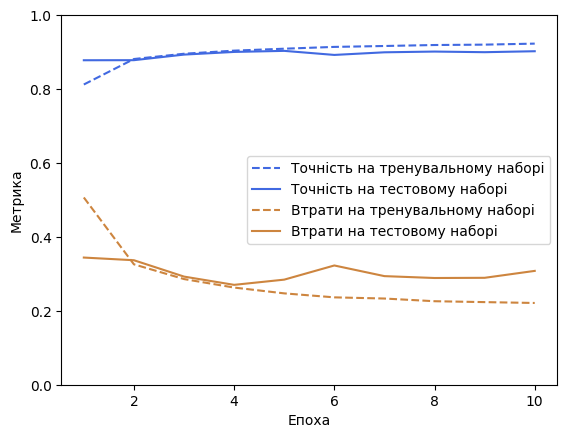

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9391 - loss: 0.1700
          тренувальні дані:   0.9386333227157593 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.2902
          тестові дані:       0.9100000262260437 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


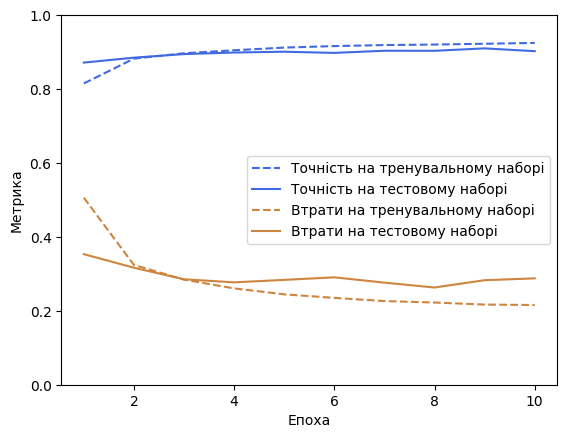

 Оптимальне значення параметра callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
   точність на тестових даних: 0.9100000262260437

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9498 - loss: 0.1372
          тренувальні дані:   0.9485333561897278 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9142 - loss: 0.2541
          тестові дані:       0.9150000214576721 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


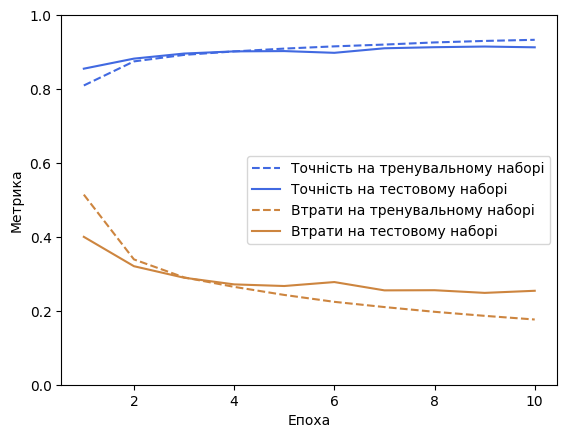

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8844 - loss: 0.3219
          тренувальні дані:   0.8822333216667175 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8739 - loss: 0.3617
          тестові дані:       0.8708999752998352 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


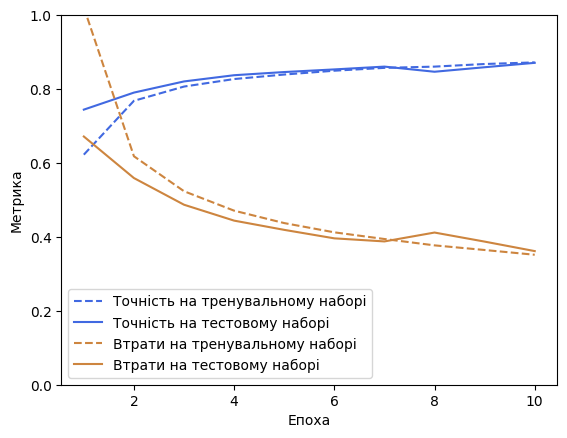

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9310 - loss: 0.1915
          тренувальні дані:   0.9302833080291748 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9022 - loss: 0.2852
          тестові дані:       0.9031000137329102 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


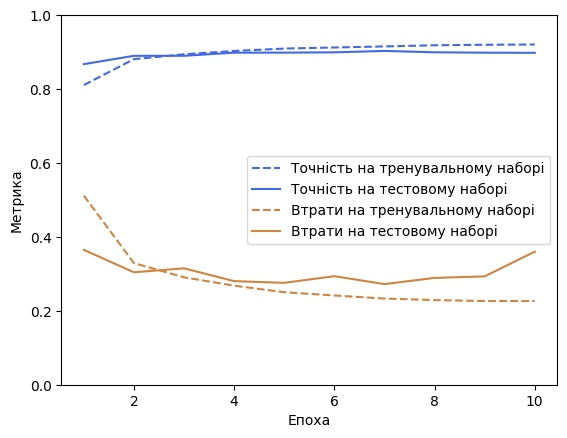

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.9150000214576721

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9504 - loss: 0.1309
          тренувальні дані:   0.9502666592597961 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9104 - loss: 0.2635
          тестові дані:       0.911300003528595 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


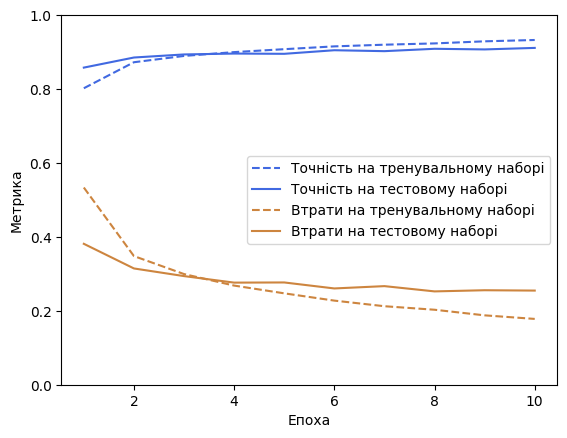

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9016 - loss: 0.2616
          тренувальні дані:   0.9007333517074585 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8801 - loss: 0.3151
          тестові дані:       0.8823000192642212 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= sigmoid
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


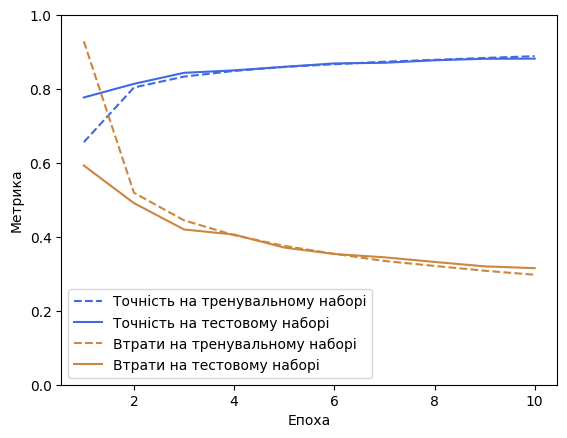

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.9150000214576721

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9414 - loss: 0.1583
          тренувальні дані:   0.9402833580970764 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9128 - loss: 0.2706
          тестові дані:       0.9129999876022339 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 16
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


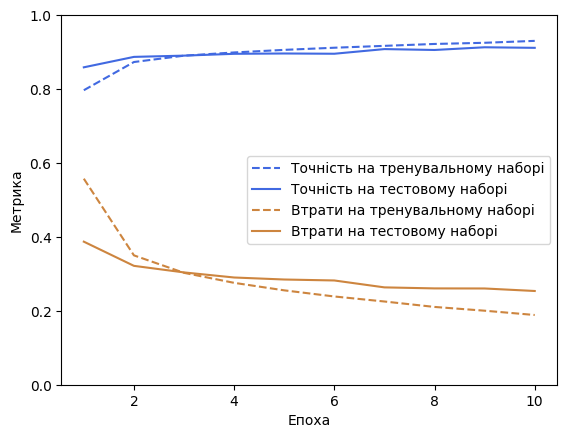

--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9397 - loss: 0.1603
          тренувальні дані:   0.939383327960968 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9049 - loss: 0.2629
          тестові дані:       0.906499981880188 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


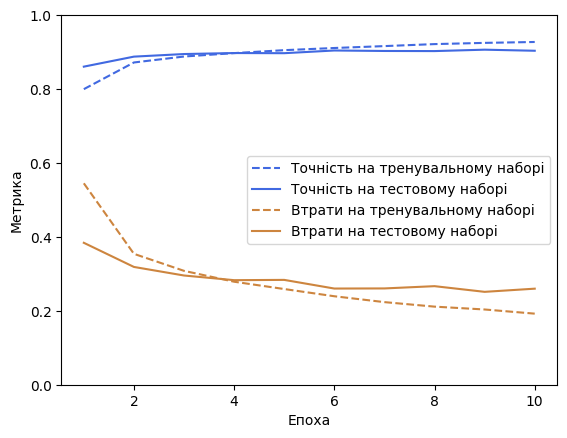

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9400 - loss: 0.1551
          тренувальні дані:   0.9397666454315186 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9091 - loss: 0.2664
          тестові дані:       0.9096999764442444 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


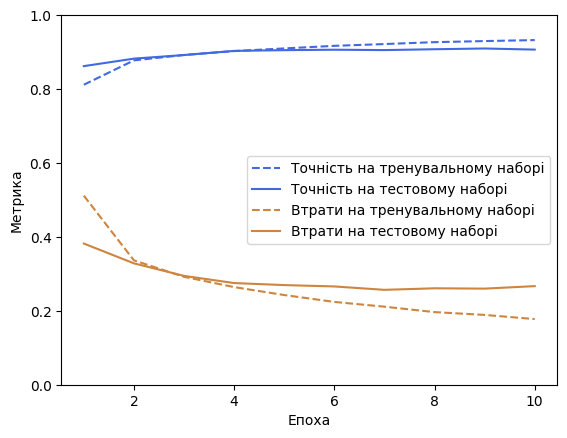

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9542 - loss: 0.1267
          тренувальні дані:   0.9531333446502686 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9116 - loss: 0.2731
          тестові дані:       0.9124000072479248 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


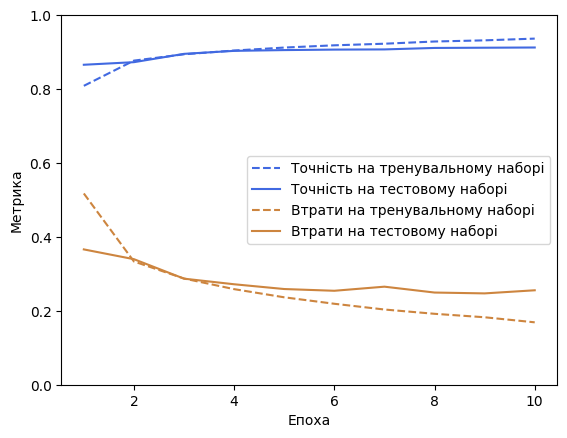

 Оптимальне значення параметра hidden_units = 64
   точність на тестових даних: 0.9150000214576721

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9349 - loss: 0.1718
          тренувальні дані:   0.9348499774932861 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9060 - loss: 0.2721
          тестові дані:       0.9090999960899353 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


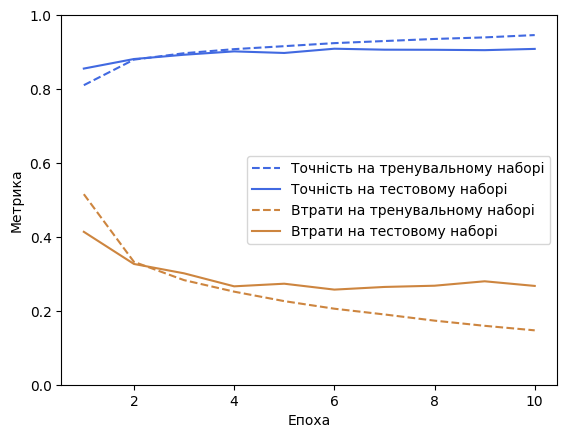

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9583 - loss: 0.1134
          тренувальні дані:   0.9582333564758301 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9159 - loss: 0.2656
          тестові дані:       0.9156000018119812 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


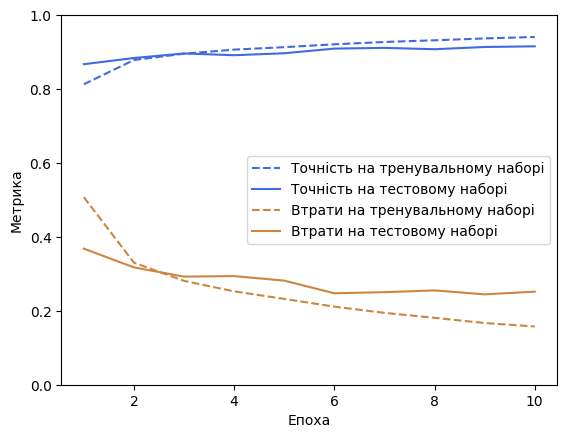

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9447 - loss: 0.1514
          тренувальні дані:   0.9436500072479248 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9124 - loss: 0.2490
          тестові дані:       0.9133999943733215 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


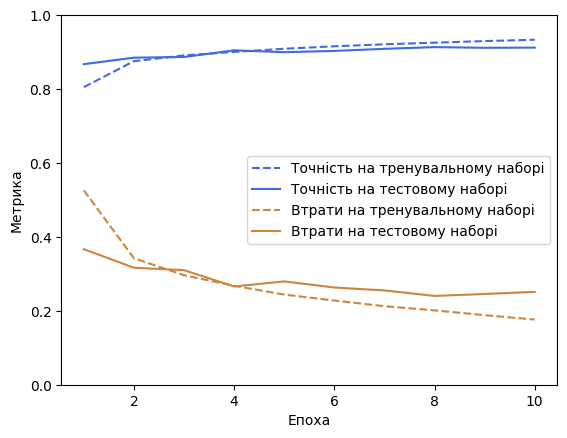

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9487 - loss: 0.1415
          тренувальні дані:   0.9474999904632568 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9195 - loss: 0.2415
          тестові дані:       0.9172000288963318 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


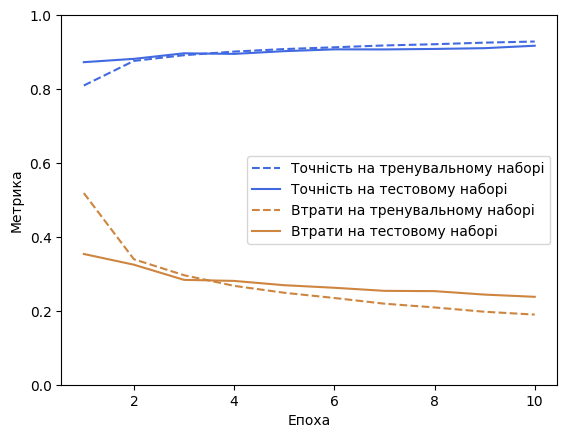

 Оптимальне значення параметра dropout_rate = 0.3
   точність на тестових даних: 0.9172000288963318

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9411 - loss: 0.1575
          тренувальні дані:   0.9402999877929688 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9077 - loss: 0.2789
          тестові дані:       0.9093999862670898 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


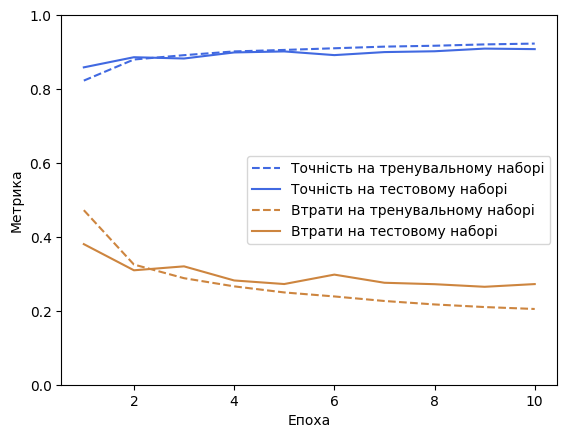

--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9462 - loss: 0.1479
          тренувальні дані:   0.9445833563804626 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9074 - loss: 0.2545
          тестові дані:       0.906499981880188 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


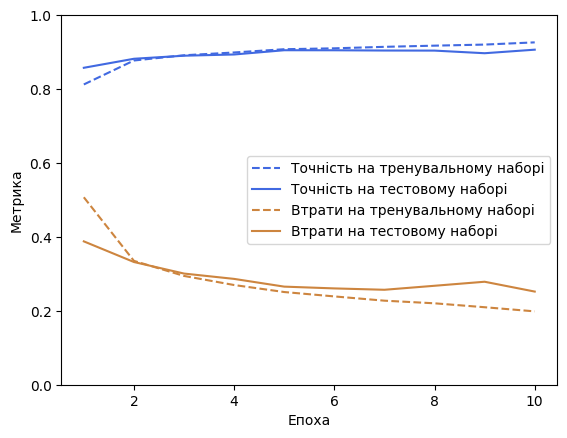

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9324 - loss: 0.1867
          тренувальні дані:   0.9312333464622498 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9065 - loss: 0.2664
          тестові дані:       0.9056000113487244 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


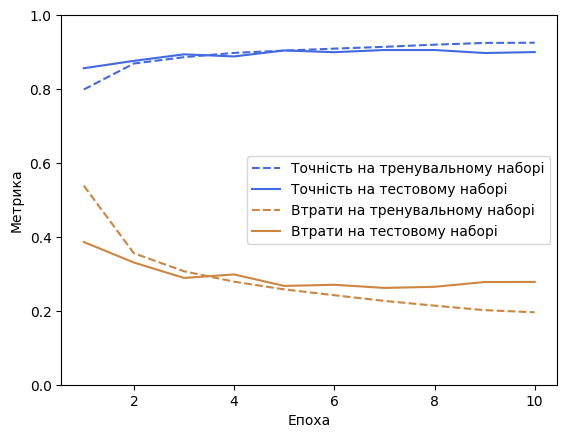

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9361 - loss: 0.1685
          тренувальні дані:   0.9337666630744934 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9051 - loss: 0.2704
          тестові дані:       0.9060999751091003 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


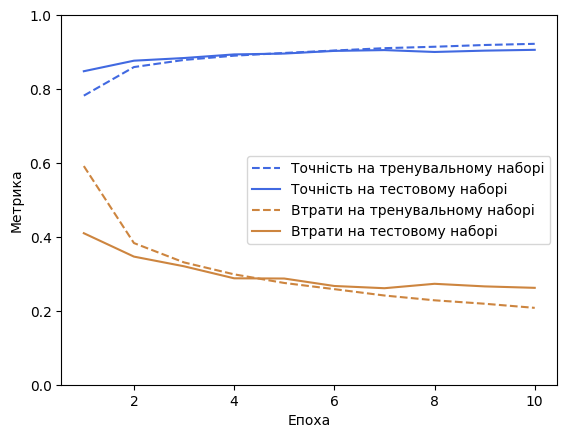

 Оптимальне значення параметра batch_size = 32
   точність на тестових даних: 0.9172000288963318

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9225 - loss: 0.2091
          тренувальні дані:   0.9216166734695435 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9029 - loss: 0.2787
          тестові дані:       0.9036999940872192 
Поточні параметри:
 epochs 	= 5
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


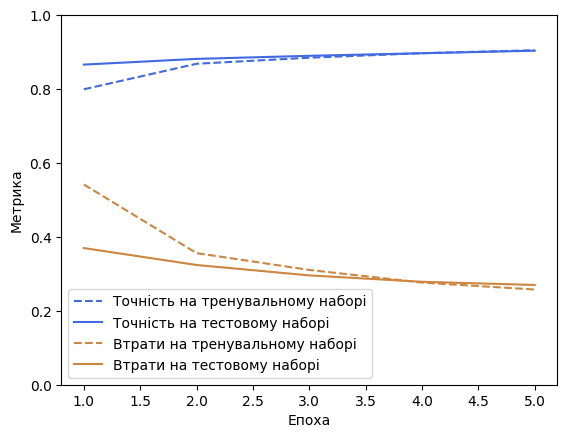

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9470 - loss: 0.1471
          тренувальні дані:   0.946066677570343 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9159 - loss: 0.2470
          тестові дані:       0.9122999906539917 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


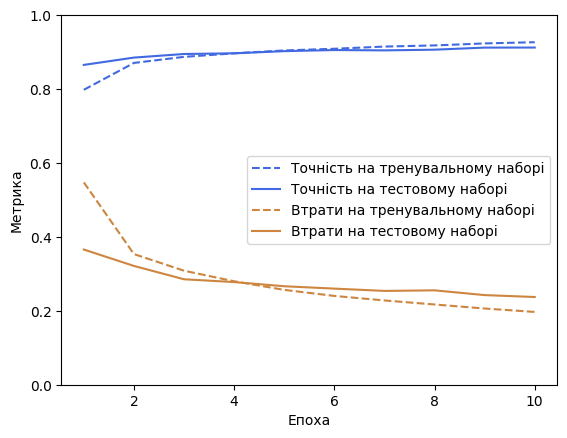

--------------------------------------------------
Тестується значення: epochs = 15
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9486 - loss: 0.1379
          тренувальні дані:   0.9480166435241699 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9169 - loss: 0.2430
          тестові дані:       0.917900025844574 
Поточні параметри:
 epochs 	= 15
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


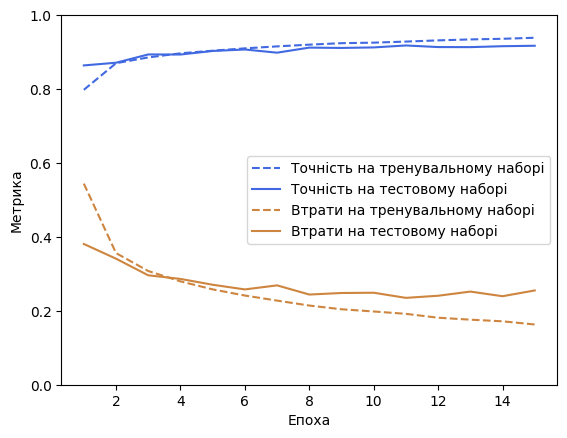

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9774 - loss: 0.0671
          тренувальні дані:   0.9761499762535095 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9199 - loss: 0.2607
          тестові дані:       0.921999990940094 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


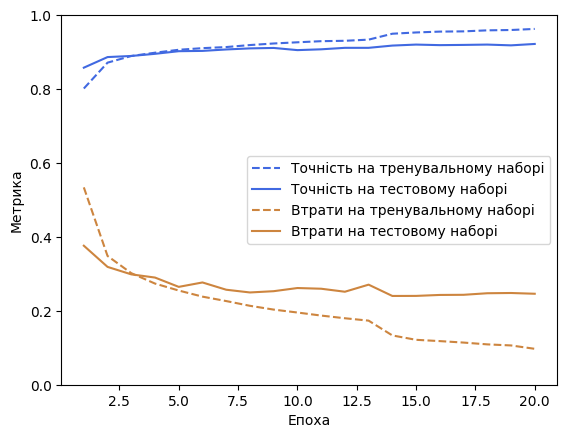

 Оптимальне значення параметра epochs = 20
   точність на тестових даних: 0.921999990940094

Пошук оптимального значення параметра: callbacks 
--------------------------------------------------
Тестується значення: callbacks = ['']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9661 - loss: 0.0911
          тренувальні дані:   0.9650499820709229 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9138 - loss: 0.2720
          тестові дані:       0.9151999950408936 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5


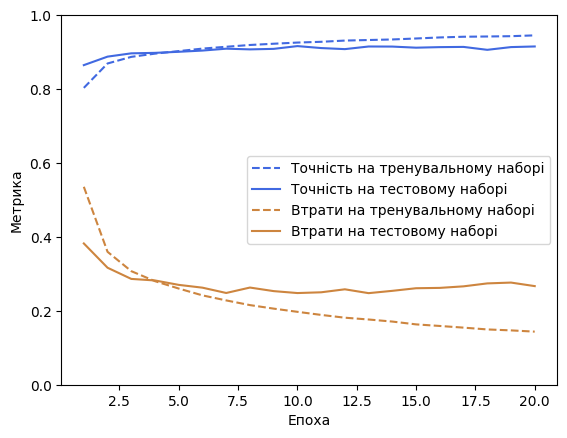

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9756 - loss: 0.0670
          тренувальні дані:   0.9754999876022339 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9174 - loss: 0.2843
          тестові дані:       0.9211000204086304 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau']
 factor_lr 	= 0.2
 patience 	= 5


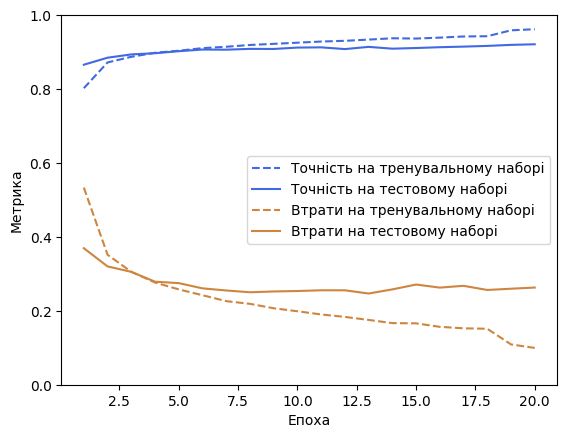

--------------------------------------------------
Тестується значення: callbacks = ['EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9678 - loss: 0.0861
          тренувальні дані:   0.9677166938781738 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9177 - loss: 0.2768
          тестові дані:       0.9200999736785889 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


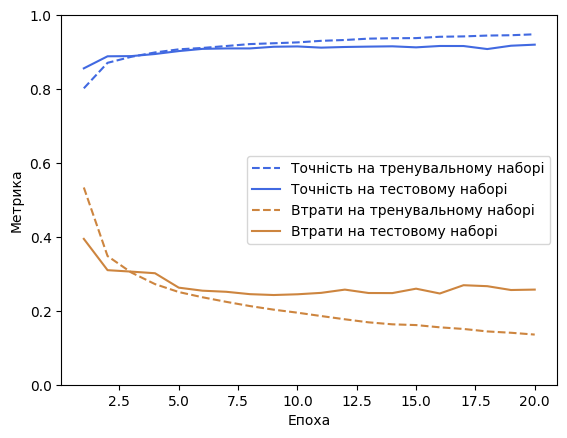

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9739 - loss: 0.0717
          тренувальні дані:   0.9732833504676819 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9256 - loss: 0.2667
          тестові дані:       0.9222999811172485 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


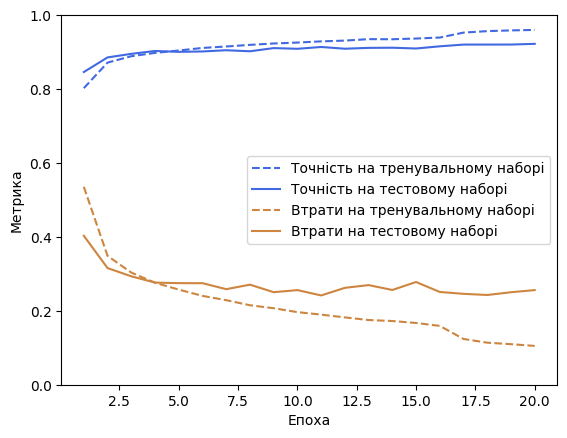

 Оптимальне значення параметра callbacks = ['ReduceLROnPlateau', 'EarlyStopping']
   точність на тестових даних: 0.9222999811172485

Пошук оптимального значення параметра: factor_lr 
--------------------------------------------------
Тестується значення: factor_lr = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9764 - loss: 0.0675
          тренувальні дані:   0.9754666686058044 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9146 - loss: 0.2631
          тестові дані:       0.9203000068664551 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


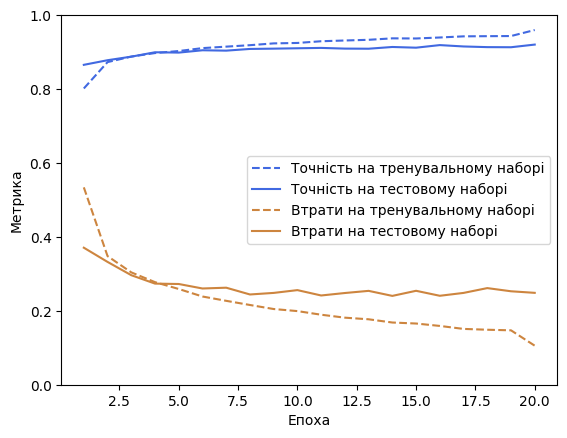

--------------------------------------------------
Тестується значення: factor_lr = 0.4
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9755 - loss: 0.0682
          тренувальні дані:   0.9750333428382874 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9221 - loss: 0.2566
          тестові дані:       0.9221000075340271 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.4
 patience 	= 5


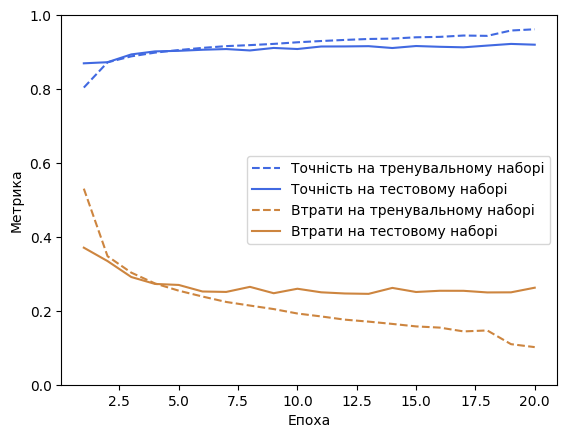

--------------------------------------------------
Тестується значення: factor_lr = 0.6
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9623 - loss: 0.1028
          тренувальні дані:   0.962149977684021 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9192 - loss: 0.2572
          тестові дані:       0.9193000197410583 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.6
 patience 	= 5


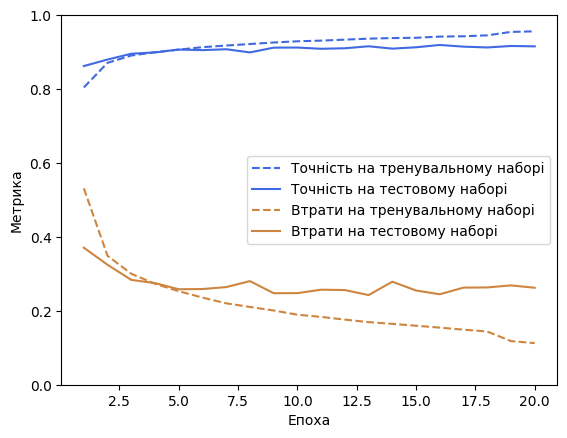

--------------------------------------------------
Тестується значення: factor_lr = 0.8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9709 - loss: 0.0846
          тренувальні дані:   0.9708666801452637 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9154 - loss: 0.2674
          тестові дані:       0.916100025177002 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.8
 patience 	= 5


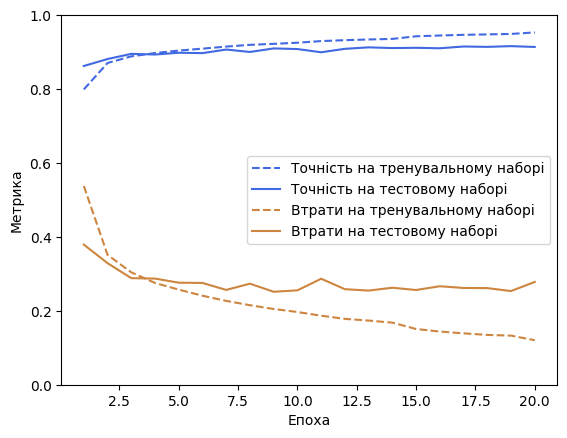

 Оптимальне значення параметра factor_lr = 0.2
   точність на тестових даних: 0.9222999811172485

Пошук оптимального значення параметра: patience 
--------------------------------------------------
Тестується значення: patience = 3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9722 - loss: 0.0779
          тренувальні дані:   0.9714166522026062 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9216 - loss: 0.2555
          тестові дані:       0.9247000217437744 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 3


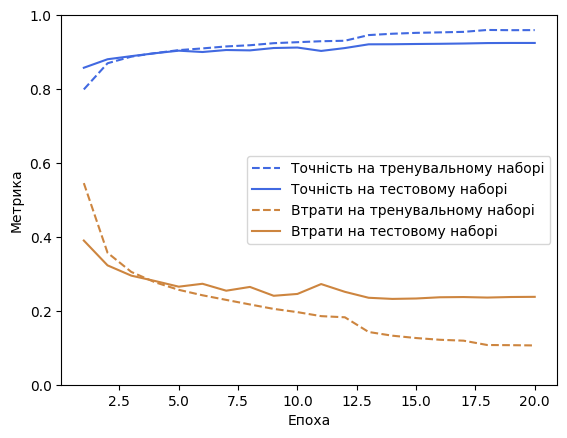

--------------------------------------------------
Тестується значення: patience = 4
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9530 - loss: 0.1284
          тренувальні дані:   0.9517333507537842 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9116 - loss: 0.2566
          тестові дані:       0.9156000018119812 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 4


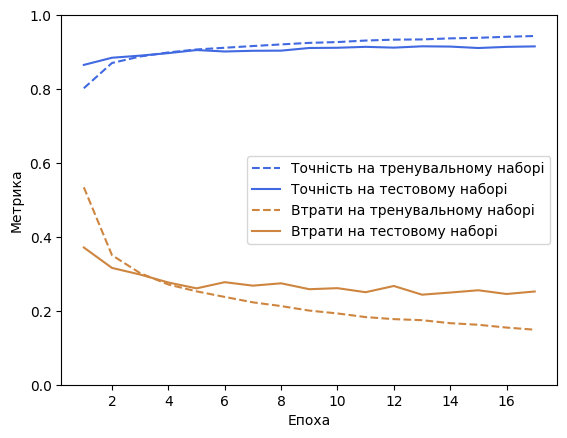

--------------------------------------------------
Тестується значення: patience = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9762 - loss: 0.0689
          тренувальні дані:   0.9752333164215088 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9200 - loss: 0.2676
          тестові дані:       0.9229000210762024 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 5


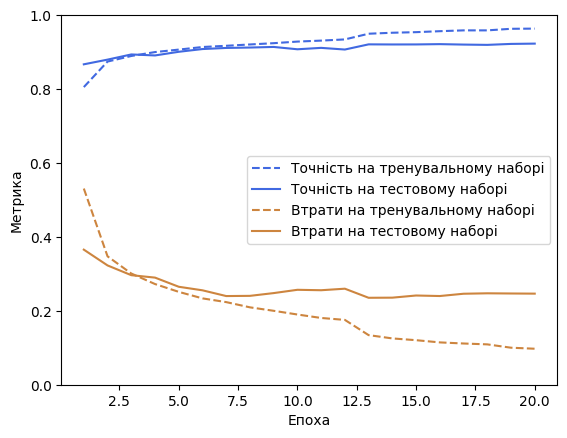

--------------------------------------------------
Тестується значення: patience = 6
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9672 - loss: 0.0905
          тренувальні дані:   0.9664166569709778 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9190 - loss: 0.2525
          тестові дані:       0.91839998960495 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 6


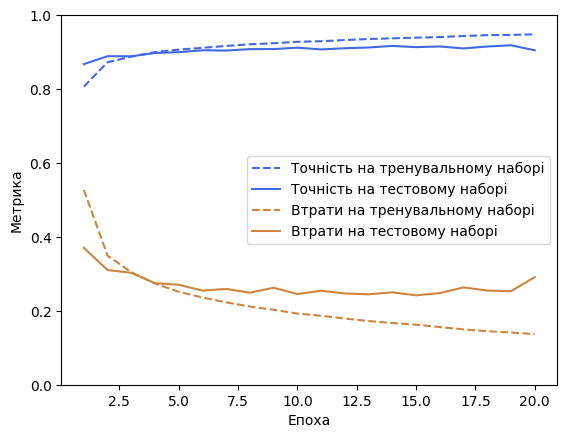

--------------------------------------------------
Тестується значення: patience = 7
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9771 - loss: 0.0692
          тренувальні дані:   0.9757000207901001 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9206 - loss: 0.2602
          тестові дані:       0.9221000075340271 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 7


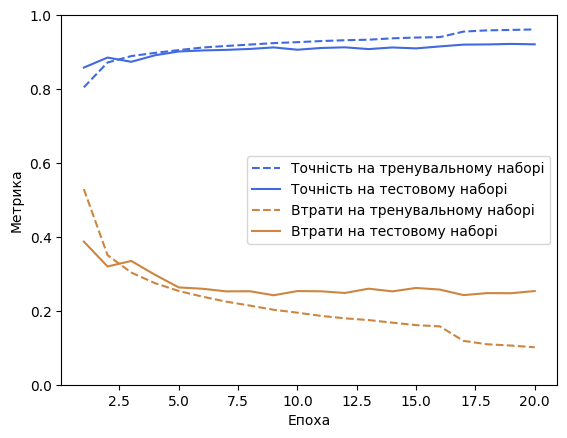

--------------------------------------------------
Тестується значення: patience = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9522 - loss: 0.1259
          тренувальні дані:   0.9517166614532471 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9164 - loss: 0.2416
          тестові дані:       0.9182000160217285 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 8


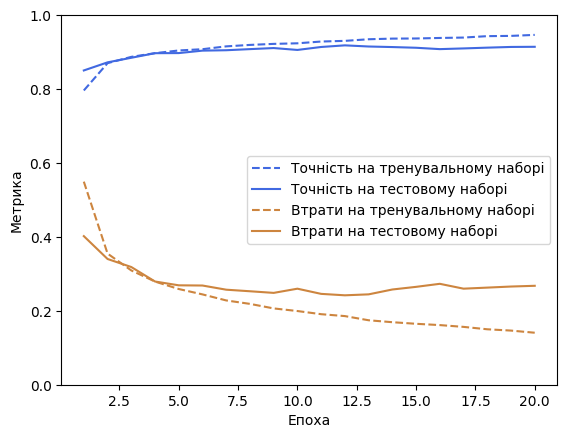

 Оптимальне значення параметра patience = 3
   точність на тестових даних: 0.9247000217437744



In [41]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_2,
    # best_accuracy,
)

In [42]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau', 'EarlyStopping']
 factor_lr 	= 0.2
 patience 	= 3
 Точність:        0.9247000217437744


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Для ускладненої моделі спостерігається <b>покращення точності</b><br>
<b>Точність на тестових даних</b> змінилася з <b>91.62%</b> для model_CNN_1 до <b>92.47%</b> для model_CNN_2</p>
</div>

```
model_CNN_2 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation="softmax"),
    ]
)
```

<div class="alert alert-block alert-info">
<b>Висновки:</b> 
<p>За результатами роботи можемо стверджувати, що згорткові нейромережі дозволяють досягати суттєво більшої точності навіть на дуже простих моделях<br>Максимальна точність на тестових даних сягнула <b>92.47%</p>
</div>